In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [2]:
res = {}
architectures = ['cnn', 'MLP', 'ResNet']
methods = ['magnitude', 'random']
scopes = ['global', 'local']
structures = ['structured', 'unstructured']
for architecture in architectures:
    for method in methods:
        for scope in scopes:
            for structure in structures:
                try:
                    res[f'{architecture}-{method}-{scope}-{structure}'] = pd.read_pickle(f'./final-results/fixed-eps-{architecture}-{method}-{scope}-{structure}.pkl')
                except:
                    pass
keys = list(res.keys())

# Helper

In [4]:
def get_robust_lp_accuracy(col, eps = 10):
        success = []
        for i in range(len(col)):
            if (np.any([type(r)==str for r in col.tolist()])):
                success = success + [True for x in range(len(col.iloc[i][0]))]
            else:
                if type(col.iloc[i]) == float:
                    print(col.iloc[i])
                success = success + [c < eps for c in col.iloc[i][0]]
        return (1 - sum(success)/len(success))
def get_robust_l_inf_accuracy(architecture, col, eps = 8):
    if architecture=='ResNet':
        epsilons = [0.125,0.25,0.5,1,2,4]
    if architecture!='ResNet':
        epsilons = [2,4,8,16,32]
        
    idx = epsilons.index(eps)

    try:
        return 1 - np.sum([col.iloc[i][idx] for i in range(len(col))]) / len(col)
    except:
        return 1
    

def calculacte_averages(architecture, keys, l0_eps = 12, l2_eps=2.5, l_inf_eps=2):
    avg_res = {}
    for key in (keys):
        #print(key)
        avg_res[key]= pd.DataFrame()
        method_results = res[key]
        ratios = method_results['pruning_ratio'].unique()
        for ratio in ratios:
            frac_ratio = 1/(1-ratio)
            a = method_results.loc[method_results['pruning_ratio'] == ratio]
            #print(l_inf_eps)
            temp_df = pd.DataFrame({
                "mean_accuracy": a['accuracy'].mean(), 
                "mean_l0_acc": get_robust_lp_accuracy(a['bb_l0'], eps = l0_eps),
                "mean_l2_acc" : get_robust_lp_accuracy(a['cw_l2'], eps = l2_eps),
                "mean_l_inf_acc" : get_robust_l_inf_accuracy(architecture, a['pgd_linf'], eps=l_inf_eps) #x/255
            },
            index=[frac_ratio]
            )
            avg_res[key] = avg_res[key].append(temp_df)
    return avg_res
        
    


def create_fixed_eps_dataframe(architecture=None,attack_type=None,l0_eps=12, l2_eps=2.5, l_inf_eps=2):
    if architecture==None or attack_type==None:
        raise ValueError('spcify architecture, and attack type')
    avg_res = calculacte_averages(architecture, keys, l0_eps=l0_eps,l2_eps=l2_eps, l_inf_eps=l_inf_eps)
    if architecture=='ResNet':
        method_keys = keys[12:]
    if architecture=='MLP':
        method_keys = keys[6:12]
    if architecture=='CNN':
        method_keys = keys[:6]
    
    l0_accs = [avg_res[key]['mean_l0_acc'] for key in method_keys]
    l0_fixed_eps_accs = []
    l2_accs = [avg_res[key]['mean_l2_acc'] for key in method_keys]
    l2_fixed_eps_accs = []
    l_inf_accs = [avg_res[key]['mean_l_inf_acc'] for key in method_keys]
    l_inf_fixed_eps_accs = []
    for key in method_keys:
        col = avg_res[key]['mean_l0_acc']
        col = col.rename(key)
        
        l0_fixed_eps_accs.append(col)
        col = avg_res[key]['mean_l2_acc']
        col = col.rename(key)
        l2_fixed_eps_accs.append(col)
        col = avg_res[key]['mean_l_inf_acc']
        col = col.rename(key)
        l_inf_fixed_eps_accs.append(col)
    l0_fixed_eps_df = pd.concat(l0_fixed_eps_accs, axis=1, sort=False)
    l2_fixed_eps_df = pd.concat(l2_fixed_eps_accs, axis=1, sort=False)
    l_inf_fixed_eps_df = pd.concat(l_inf_fixed_eps_accs, axis=1, sort=False)
    if attack_type==None:
        return False
    if attack_type=='l0':
        return l0_fixed_eps_df
    if attack_type=='l2':
        return l2_fixed_eps_df 
    if attack_type=='l_inf':
        return l_inf_fixed_eps_df
    
def create_fixed_ratio_dataframe(architecture=None, attack_type=None):
    if architecture==None or attack_type==None:
        raise ValueError('spcify architecture, and attack type')
    avg_res = calculacte_averages(architecture, keys,)
    if architecture=='MLP':
        keys = keys[6:12]
    if architecture=='CNN':
        keys = keys[:6]
    if architecture=='ResNet':
        keys = keys[12:]
    RATIO_TO_EXAMINE = 4
    epsilons = [2,4,8,16,32]

    avg_robust_accuracies = {}
    ratio_to_examine = 1 - 1 / RATIO_TO_EXAMINE
    
    for key in (keys):
        #print(key)
        method_results = res[key]
        fixed_ratio_results = method_results.loc[method_results['pruning_ratio'] == ratio_to_examine]
        #print(fixed_ratio_results)
        temp_list = []
        if attack_type == 'l_inf':
            for fixed_ratio_result in fixed_ratio_results['pgd_linf']:
                temp_list.append(fixed_ratio_result)
        if attack_type == 'l2':
            temp_list.append([get_robust_lp_accuracy(fixed_ratio_results['cw_l2'], eps = eps) for eps in epsilons])
        if attack_type == 'l0':
            temp_list.append([get_robust_lp_accuracy(fixed_ratio_results['bb_l0'], eps = eps) for eps in epsilons])
            #print('yo',get_robust_lp_accuracy(fixed_ratio_results['bb_l0'], eps = 12))
            
            
        vals_per_eps = pd.DataFrame(temp_list, columns=epsilons)
        vals_per_eps.mean(axis=0)
        if attack_type=='l_inf':
            avg_robust_accuracies[key]=(1-vals_per_eps.mean(axis=0))
        else:
            avg_robust_accuracies[key]=(vals_per_eps.mean(axis=0))
    fixed_eps_robust_accuracies = pd.DataFrame(avg_robust_accuracies)
    return fixed_eps_robust_accuracies


def plot_graphic(fixed_eps_df, fixed_ratio_df, title_1=None, title_2=None,x_axis_label_1=None, y_axis_label_1=None, x_axis_label_2=None, y_axis_label_2=None):
    fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, gridspec_kw={'wspace': 0.05, hspace:0.5})
    axes = axes.flatten()


    x = fixed_eps_df.plot(marker='o', markersize=15,figsize=(40,10), fontsize=16, linewidth=5, ax=axes[0])
    x.set_title(title_1, fontsize=32)
    x.set_xscale('log')
    x.set_xticks([1,2,4,8,16,32,64])
    x.set_xticklabels([1,2,4,8,16,32,64] )
    x.minorticks_off()
    x.set_xlabel(x_axis_label_1, fontsize=22)
    x.set_ylabel(y_axis_label_1, fontsize=22)
    x.legend(prop={'size': 16})


    x = fixed_ratio_df.plot(marker='o', markersize=15, figsize=(40,10), fontsize=16, linewidth=5, ax=axes[1])
    x.set_xscale('log')
    x.set_xticks([2,4,8,16,32])
    
    x.set_title(title_2, fontsize=32)
    x.set_xscale('log')
    x.set_xticks([2,4,8,16,32])
    x.set_xticklabels([2,4,8,16,32] )
    x.minorticks_off()
    x.set_xlabel(x_axis_label_2, fontsize=22)
    x.set_ylabel(y_axis_label_2, fontsize=22)
    x.legend(prop={'size': 16})
    
def plot_graphic(fixed_eps_dfs=None, title=None,x_axis_label=None, y_axis_label=None, eps=None, figname=None, infty=False):
    if fixed_eps_dfs ==None or figname==None:
        raise ValueError('you need to provide dfs and figname to plot')
        
    fig, axes = plt.subplots(ncols=2, nrows=2, sharey=True, gridspec_kw={'wspace': 0.05, 'hspace':.3})
    axes = axes.flatten()
    
    for i, fixed_eps_df in enumerate(fixed_eps_dfs):
        if infty == False:
            full_title = title+str(eps[i])
        if infty == True:
            full_title = title+str(eps[i]) + ' / 255'
        x = fixed_eps_df.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[i])
        x.set_title(full_title, fontsize=40)
        x.set_xscale('log')
        x.set_xticks([1,2,4,8,16,32,64])
        x.set_xticklabels([1,2,4,8,16,32,64] )
        x.minorticks_off()
        x.set_xlabel(x_axis_label, fontsize=32)
        x.set_ylabel(y_axis_label, fontsize=32)
        if i==3:
            x.legend(prop={'size': 28})
        else:
            x.get_legend().remove()
    #fig.tight_layout()
    fig.savefig(f'./graphics/{figname}.png', dpi=72, bbox_inches='tight')
    

# MLP

## $L_0$-Attack

In [5]:
local_eps = [4,8,16,32]
mlp_l0_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l0', architecture='MLP', l0_eps=eps) for eps in local_eps]
#mlp_l0_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l0', architecture='MLP')

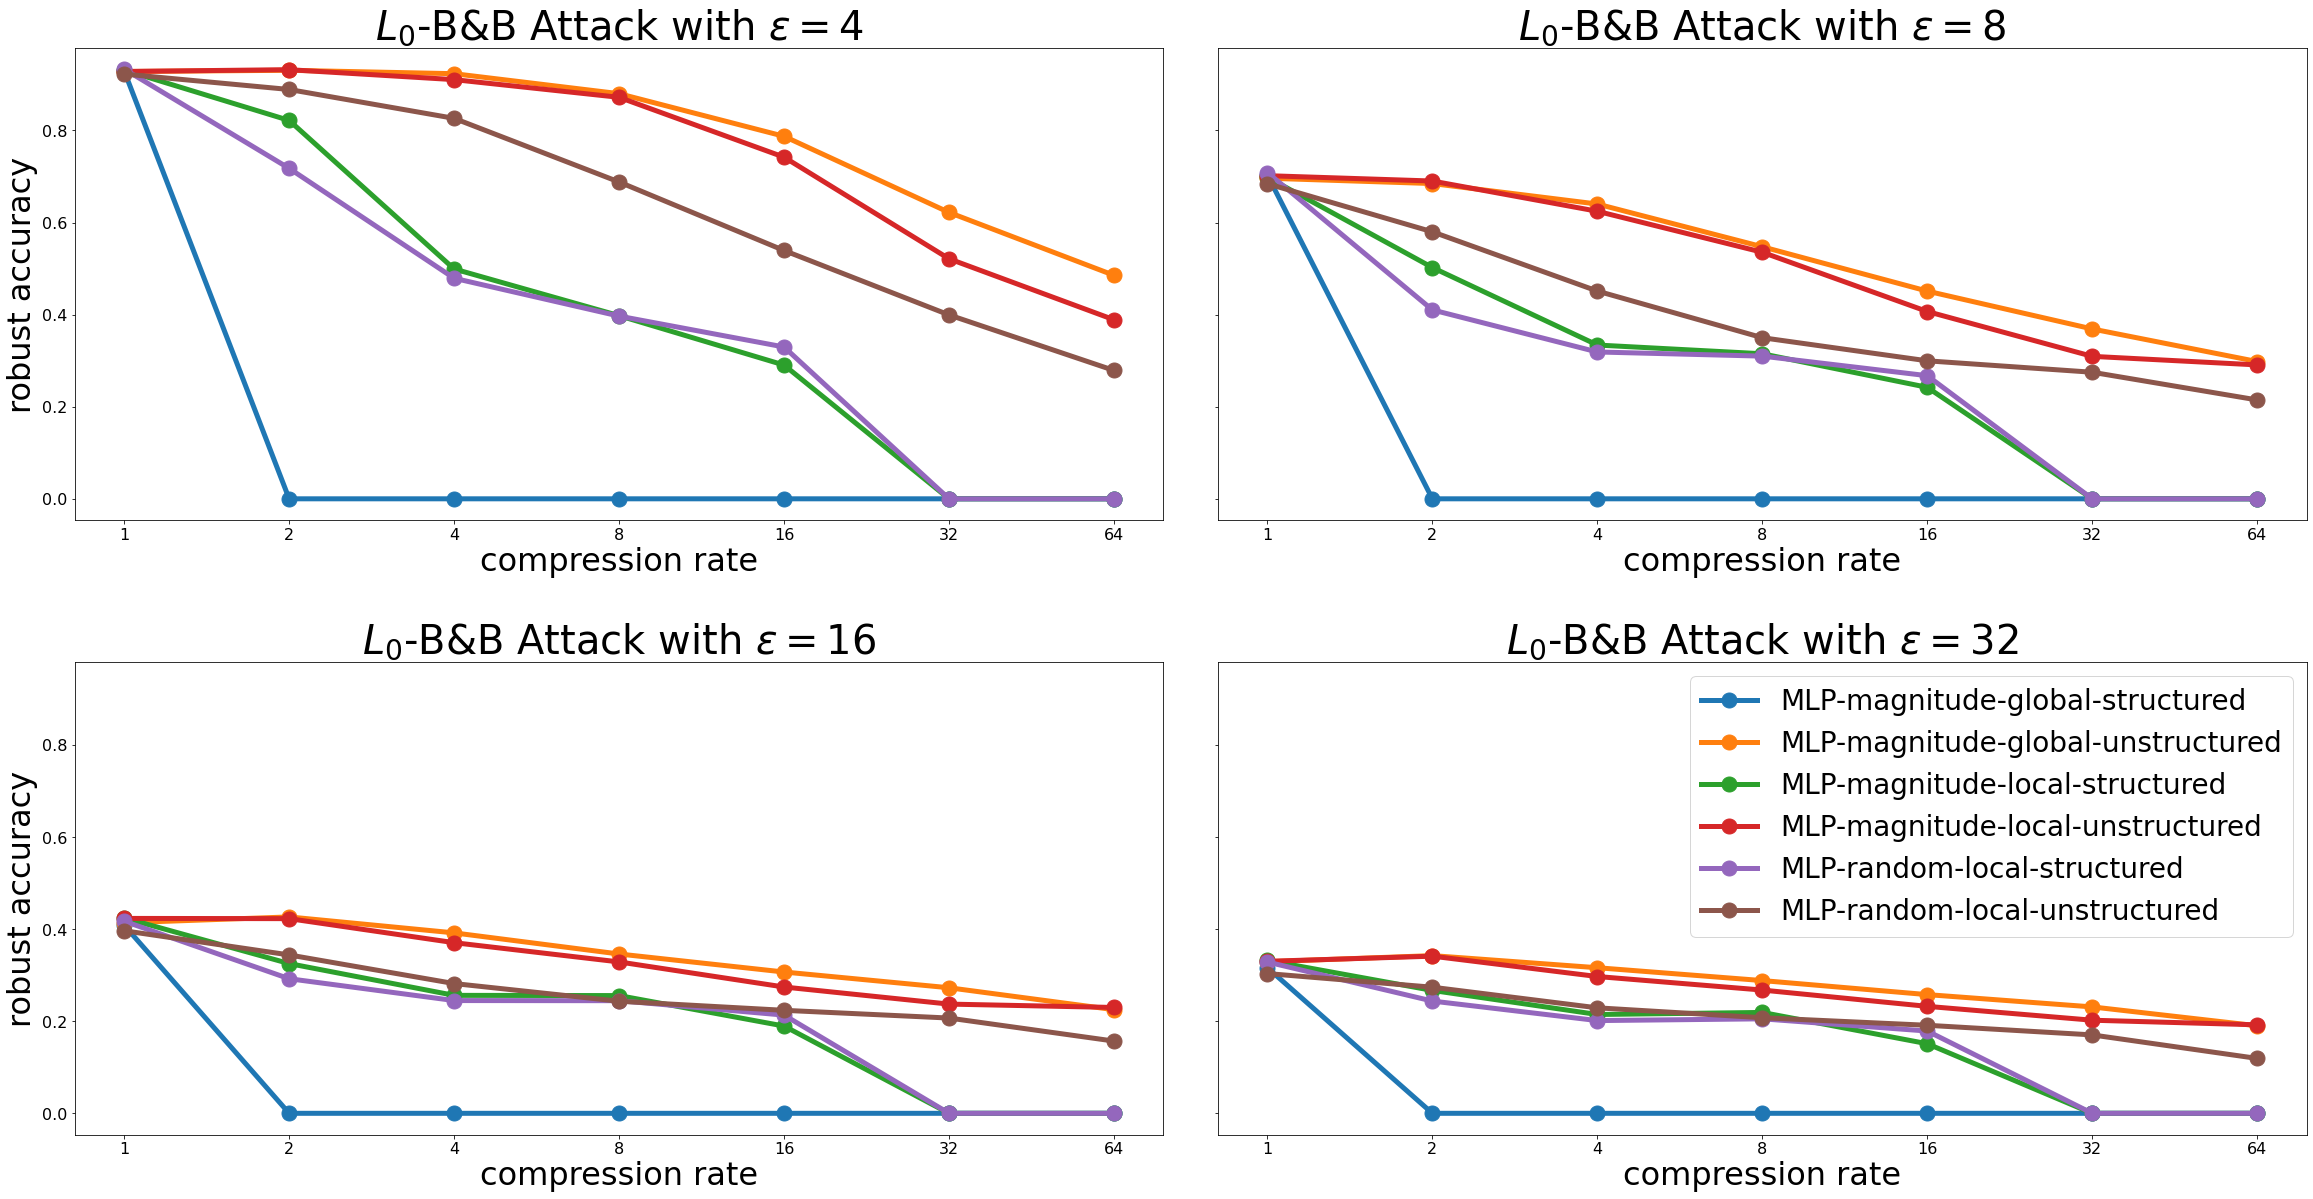

In [6]:
plot_graphic(
    mlp_l0_fixed_eps_dfs, 
    title=fr'$L_0$-B&B Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=[4,8,16,32],
    figname='mlp_l0_fixed_eps'
)

## $L_2$-Attack

In [8]:
local_eps = [1,2,3,4]
mlp_l2_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l2', architecture='MLP', l2_eps=eps) for eps in local_eps]
#mlp_l2_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l2', architecture='MLP')


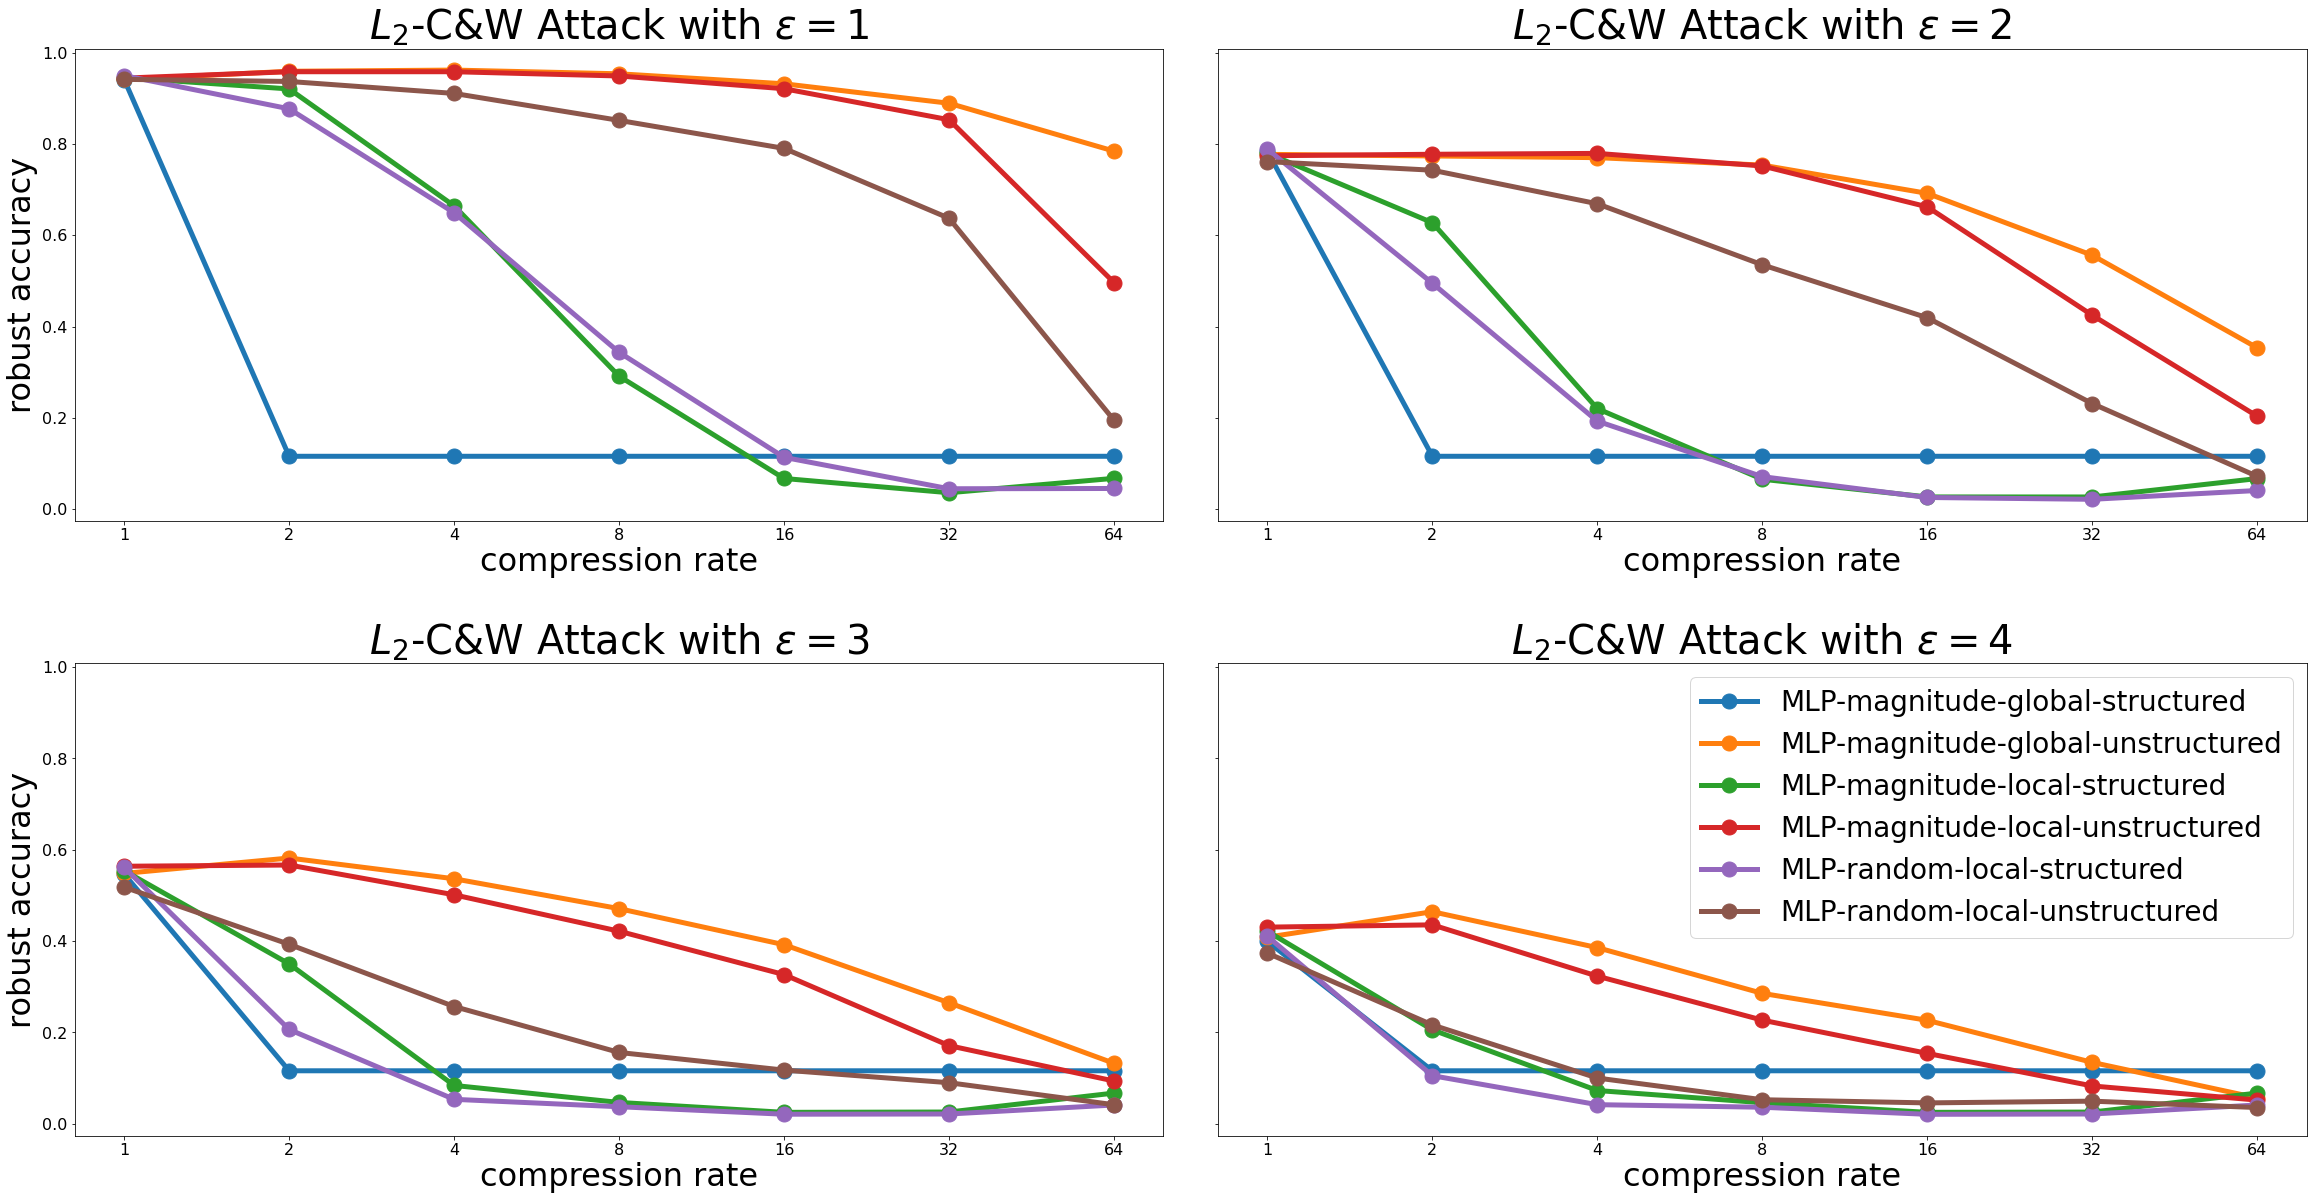

In [9]:
plot_graphic(
    mlp_l2_fixed_eps_dfs, 
    title=r'$L_2$-C&W Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='mlp_l2_fixed_eps'
)



## $L_\infty$-Attack

In [10]:
local_eps=[4,8,16,32]
mlp_l_inf_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l_inf', architecture='MLP', l_inf_eps=eps) for eps in local_eps]
#mlp_l_inf_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l_inf', architecture='MLP')

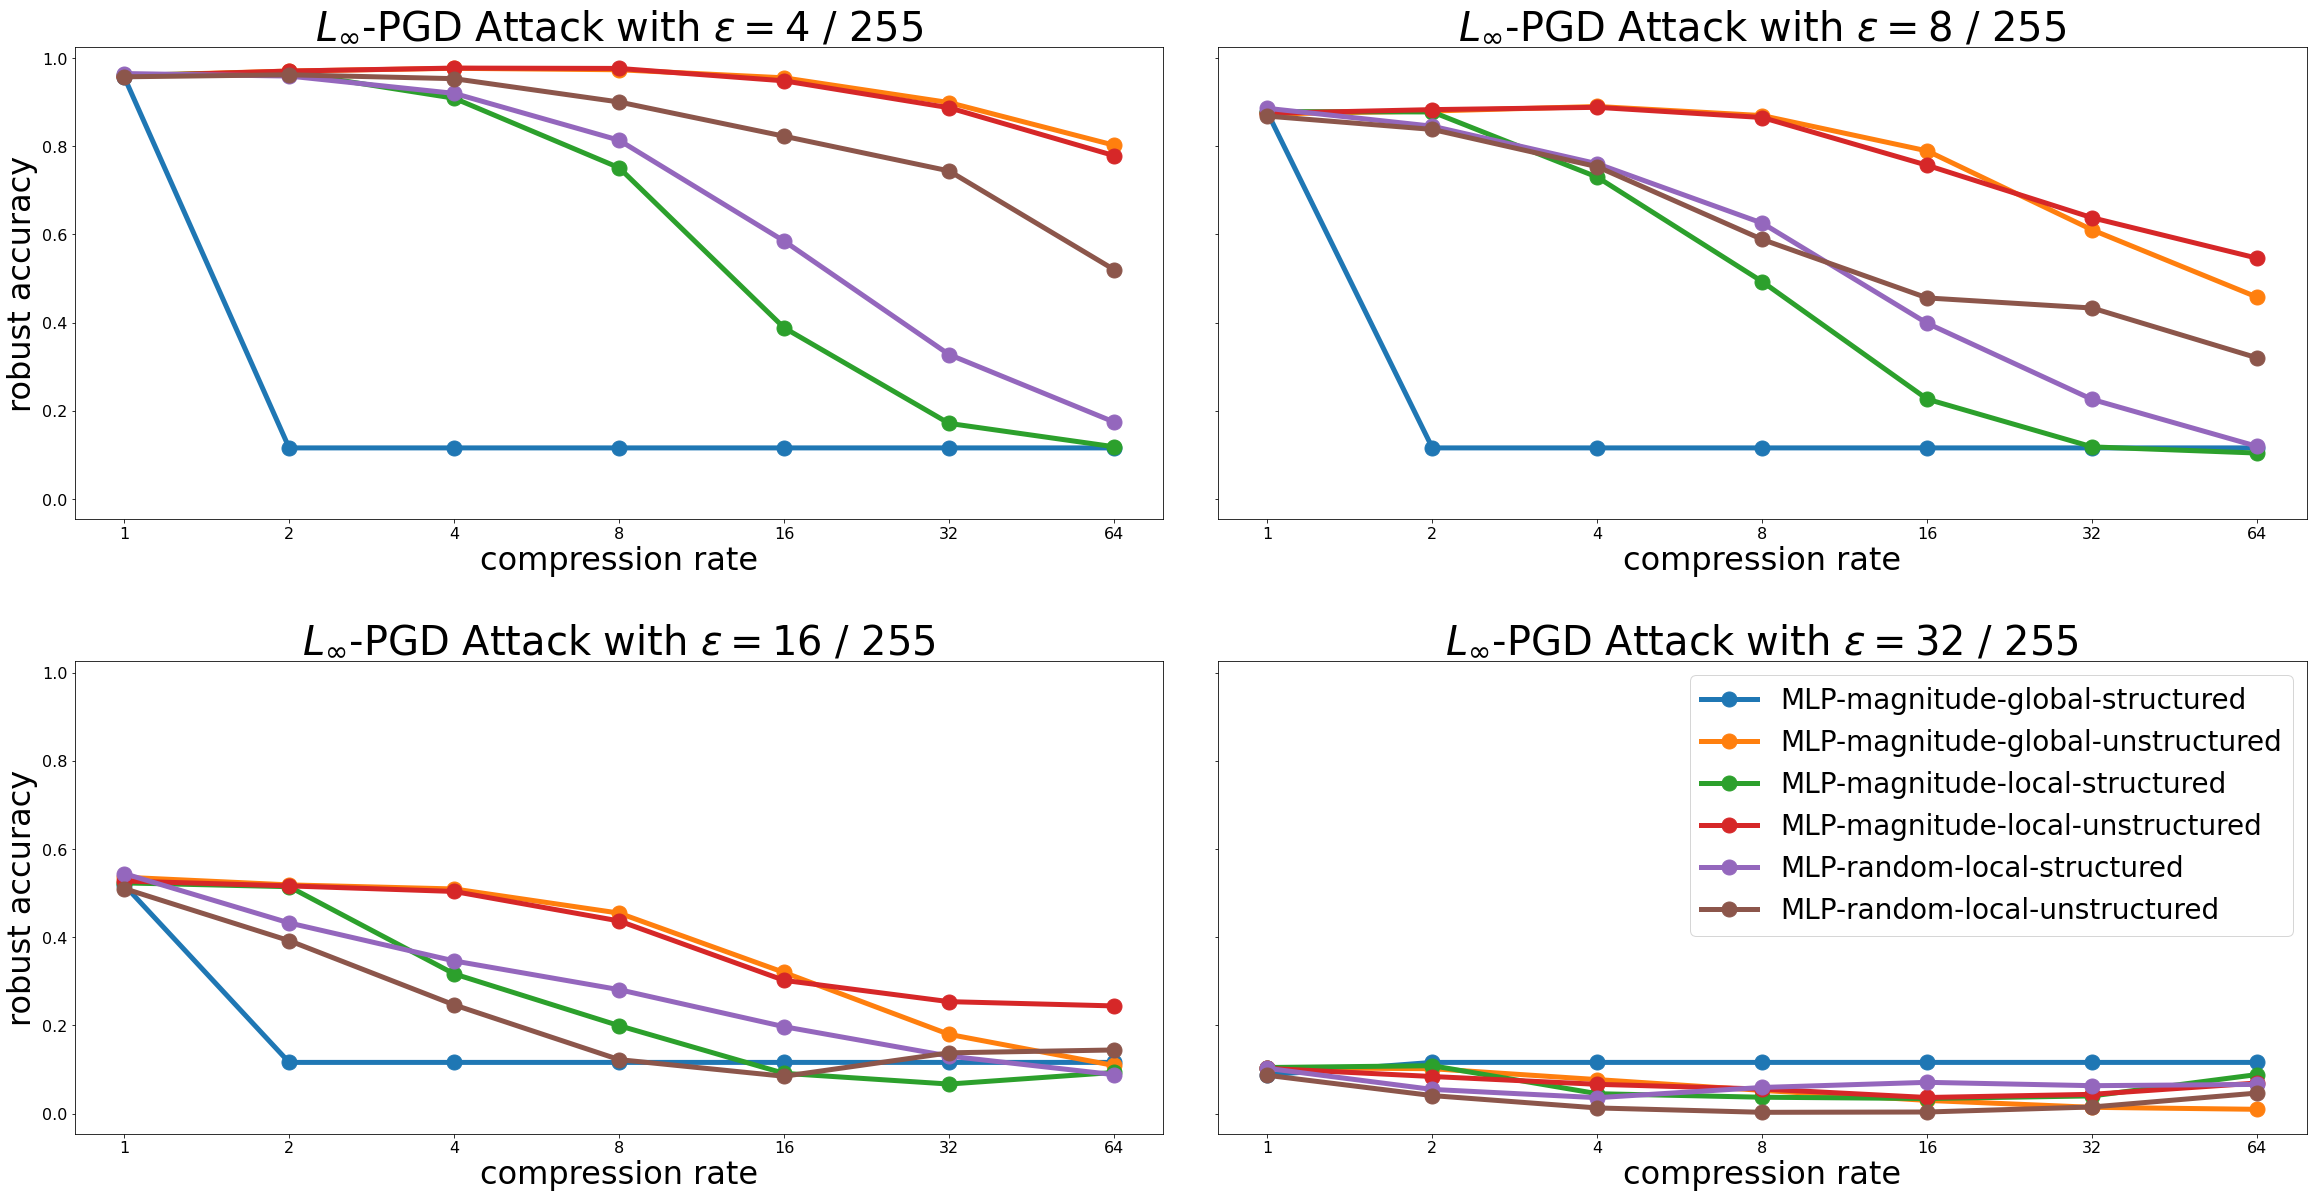

In [11]:
plot_graphic(
    mlp_l_inf_fixed_eps_dfs, 
    title=r'$L_\infty$-PGD Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='mlp_l_inf_fixed_eps',
    infty=True
)

# CNN-s

## $L_0$-Attack

In [12]:
local_eps=[4,8,16,32]
cnn_l0_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l0', architecture='CNN', l0_eps=eps) for eps in local_eps]
#cnn_l0_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l_inf', architecture='CNN')

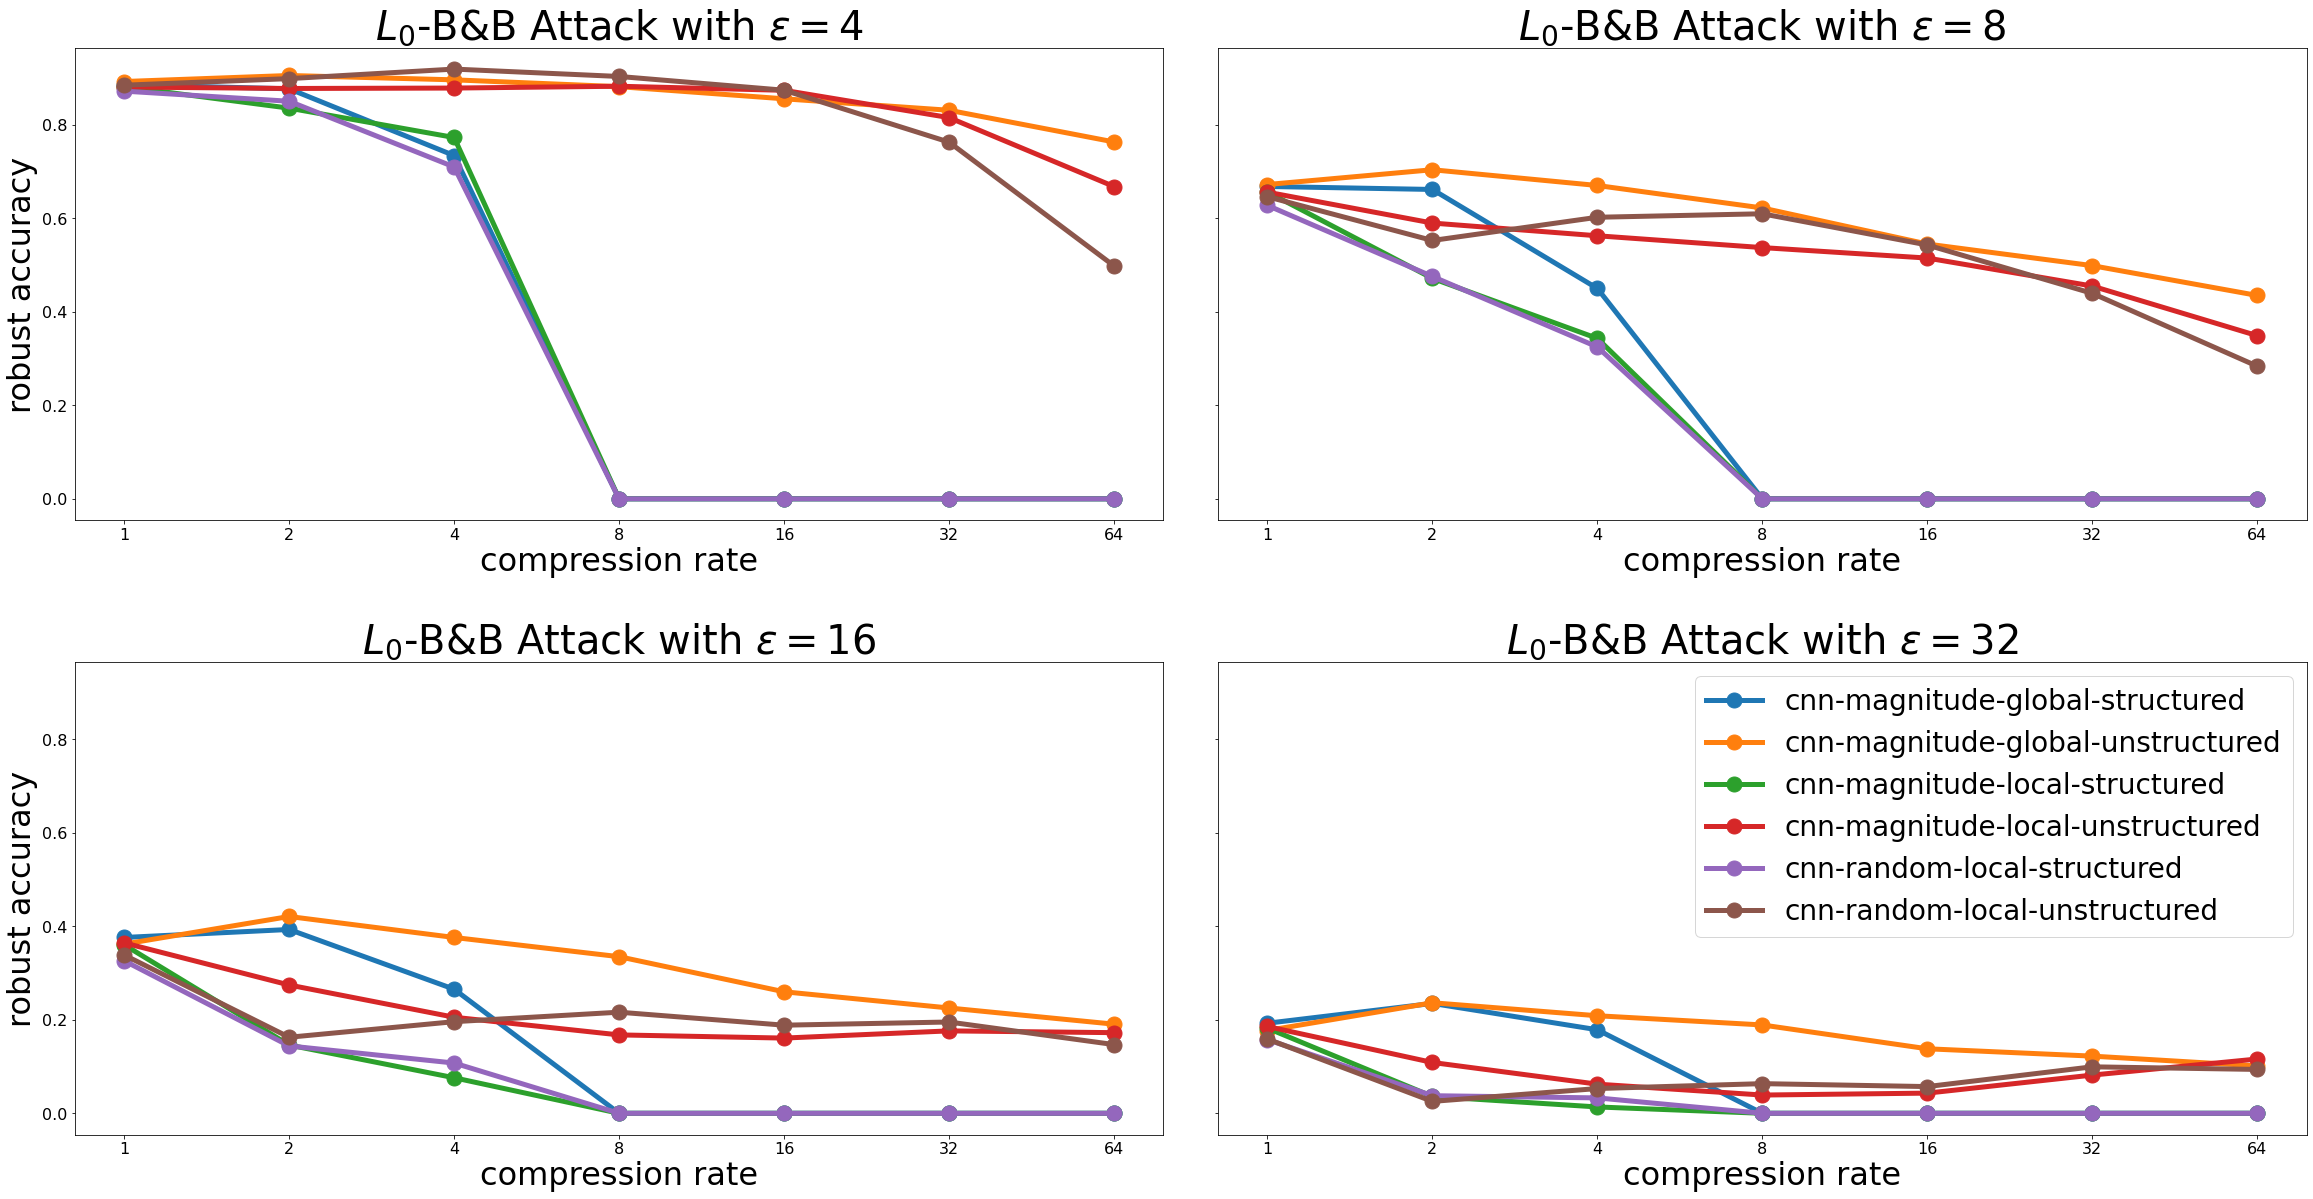

In [13]:
plot_graphic(
    cnn_l0_fixed_eps_dfs, 
    title=r'$L_0$-B&B Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='cnn_l0_fixed_eps'
)


## $L_2$-Attack

In [14]:
local_eps = [1,2,3,4]
cnn_l2_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l2', architecture='CNN', l2_eps=eps) for eps in local_eps]
#cnn_l2_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l2', architecture='CNN')

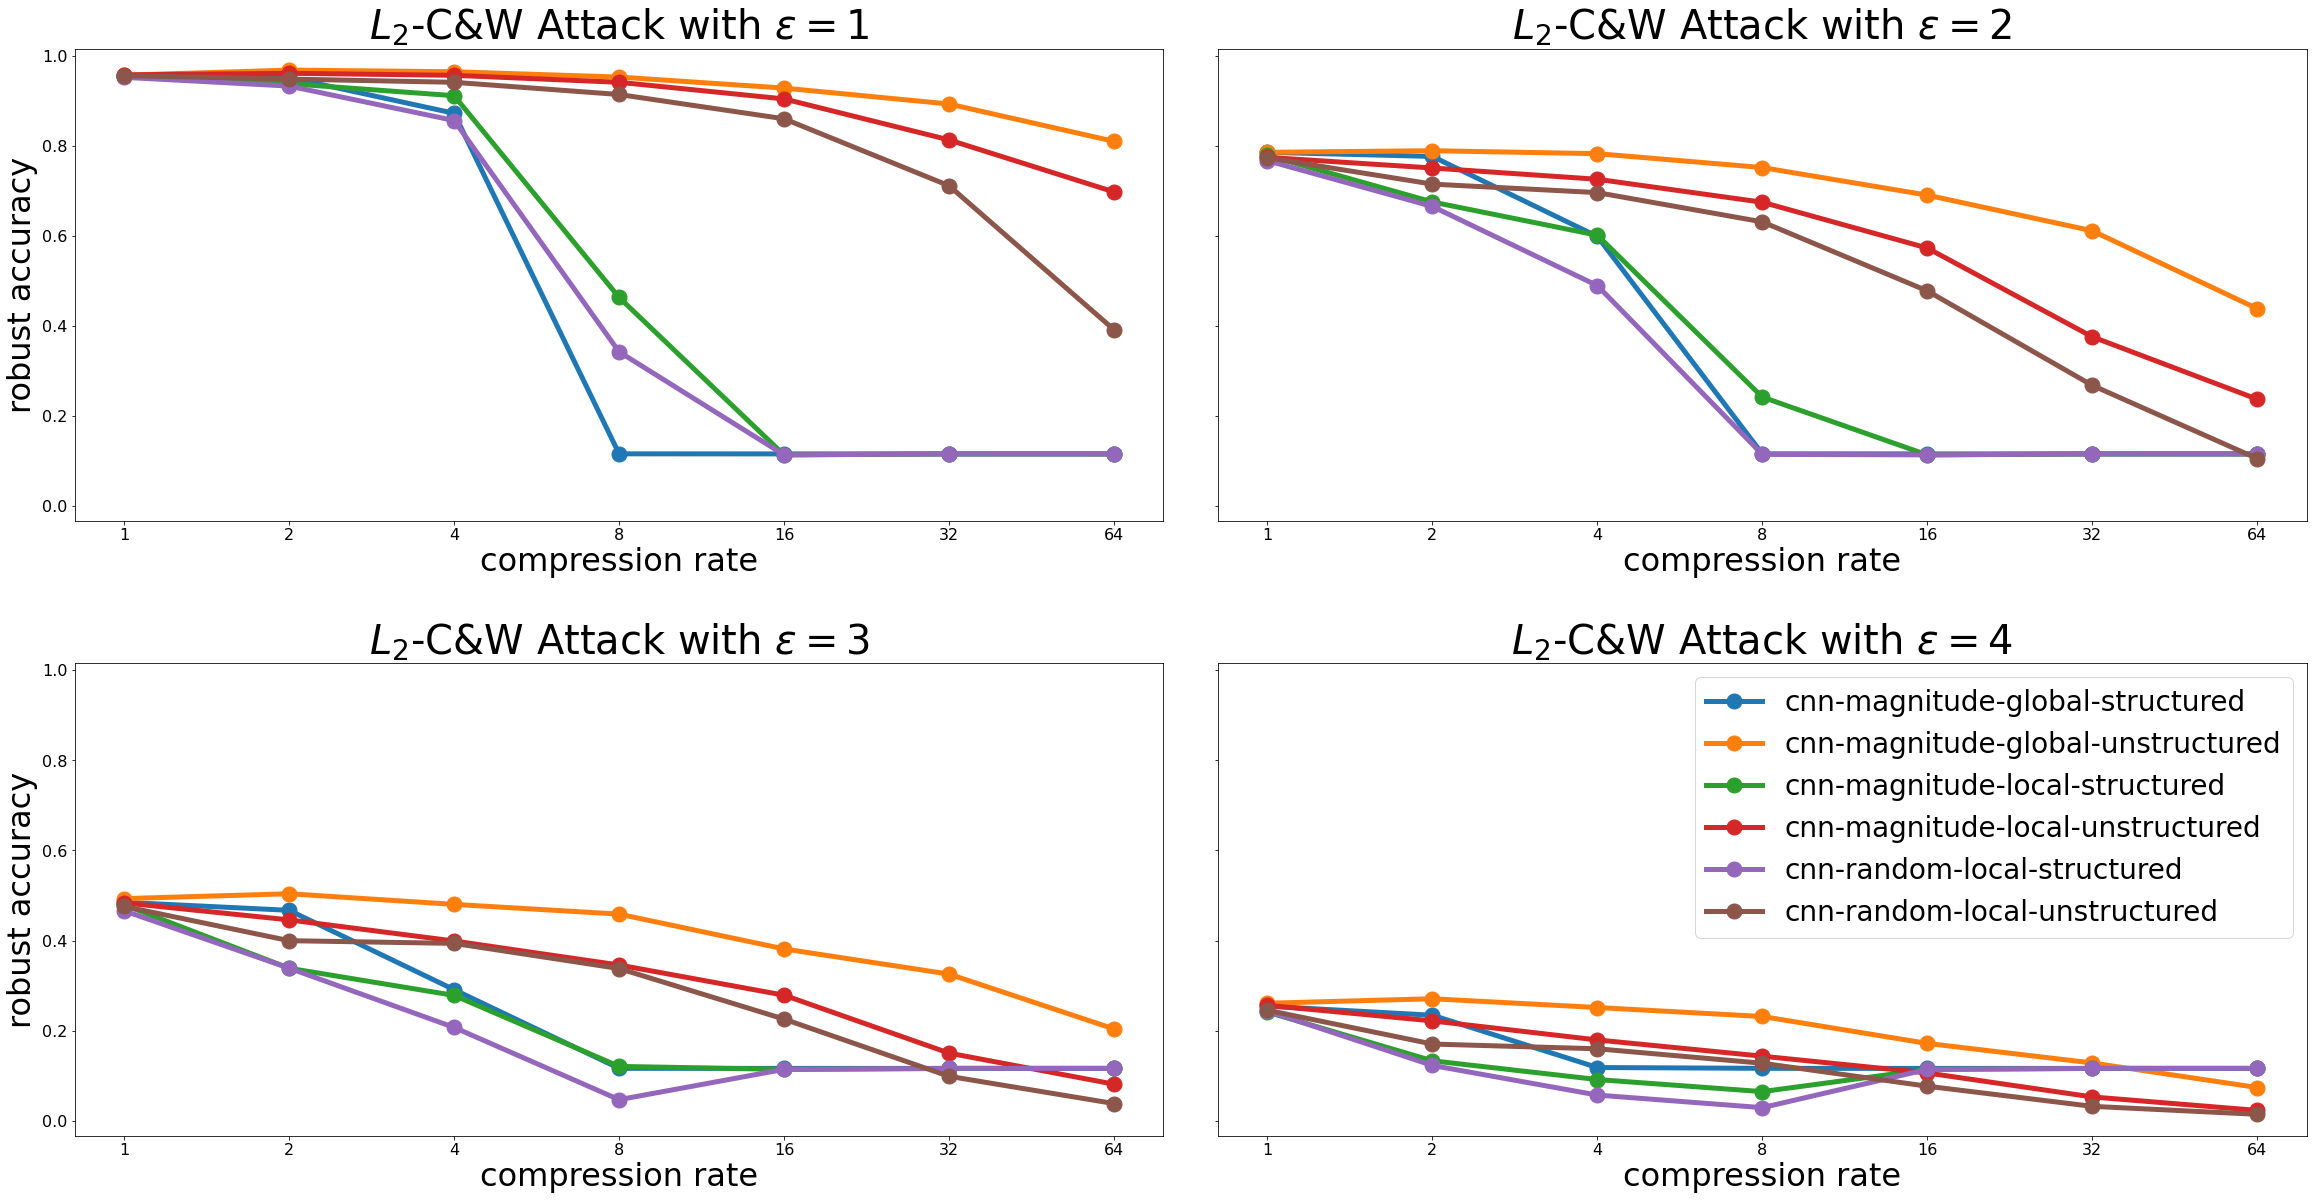

In [15]:
plot_graphic(
    cnn_l2_fixed_eps_dfs, 
    title=r'$L_2$-C&W Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='cnn_l2_fixed_eps'
)


## $L_\infty$-Attack

In [16]:
local_eps=[2,4,8,16]
cnn_l_inf_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l_inf', architecture='CNN', l_inf_eps=eps) for eps in local_eps]
#cnn_l_inf_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l_inf', architecture='CNN')

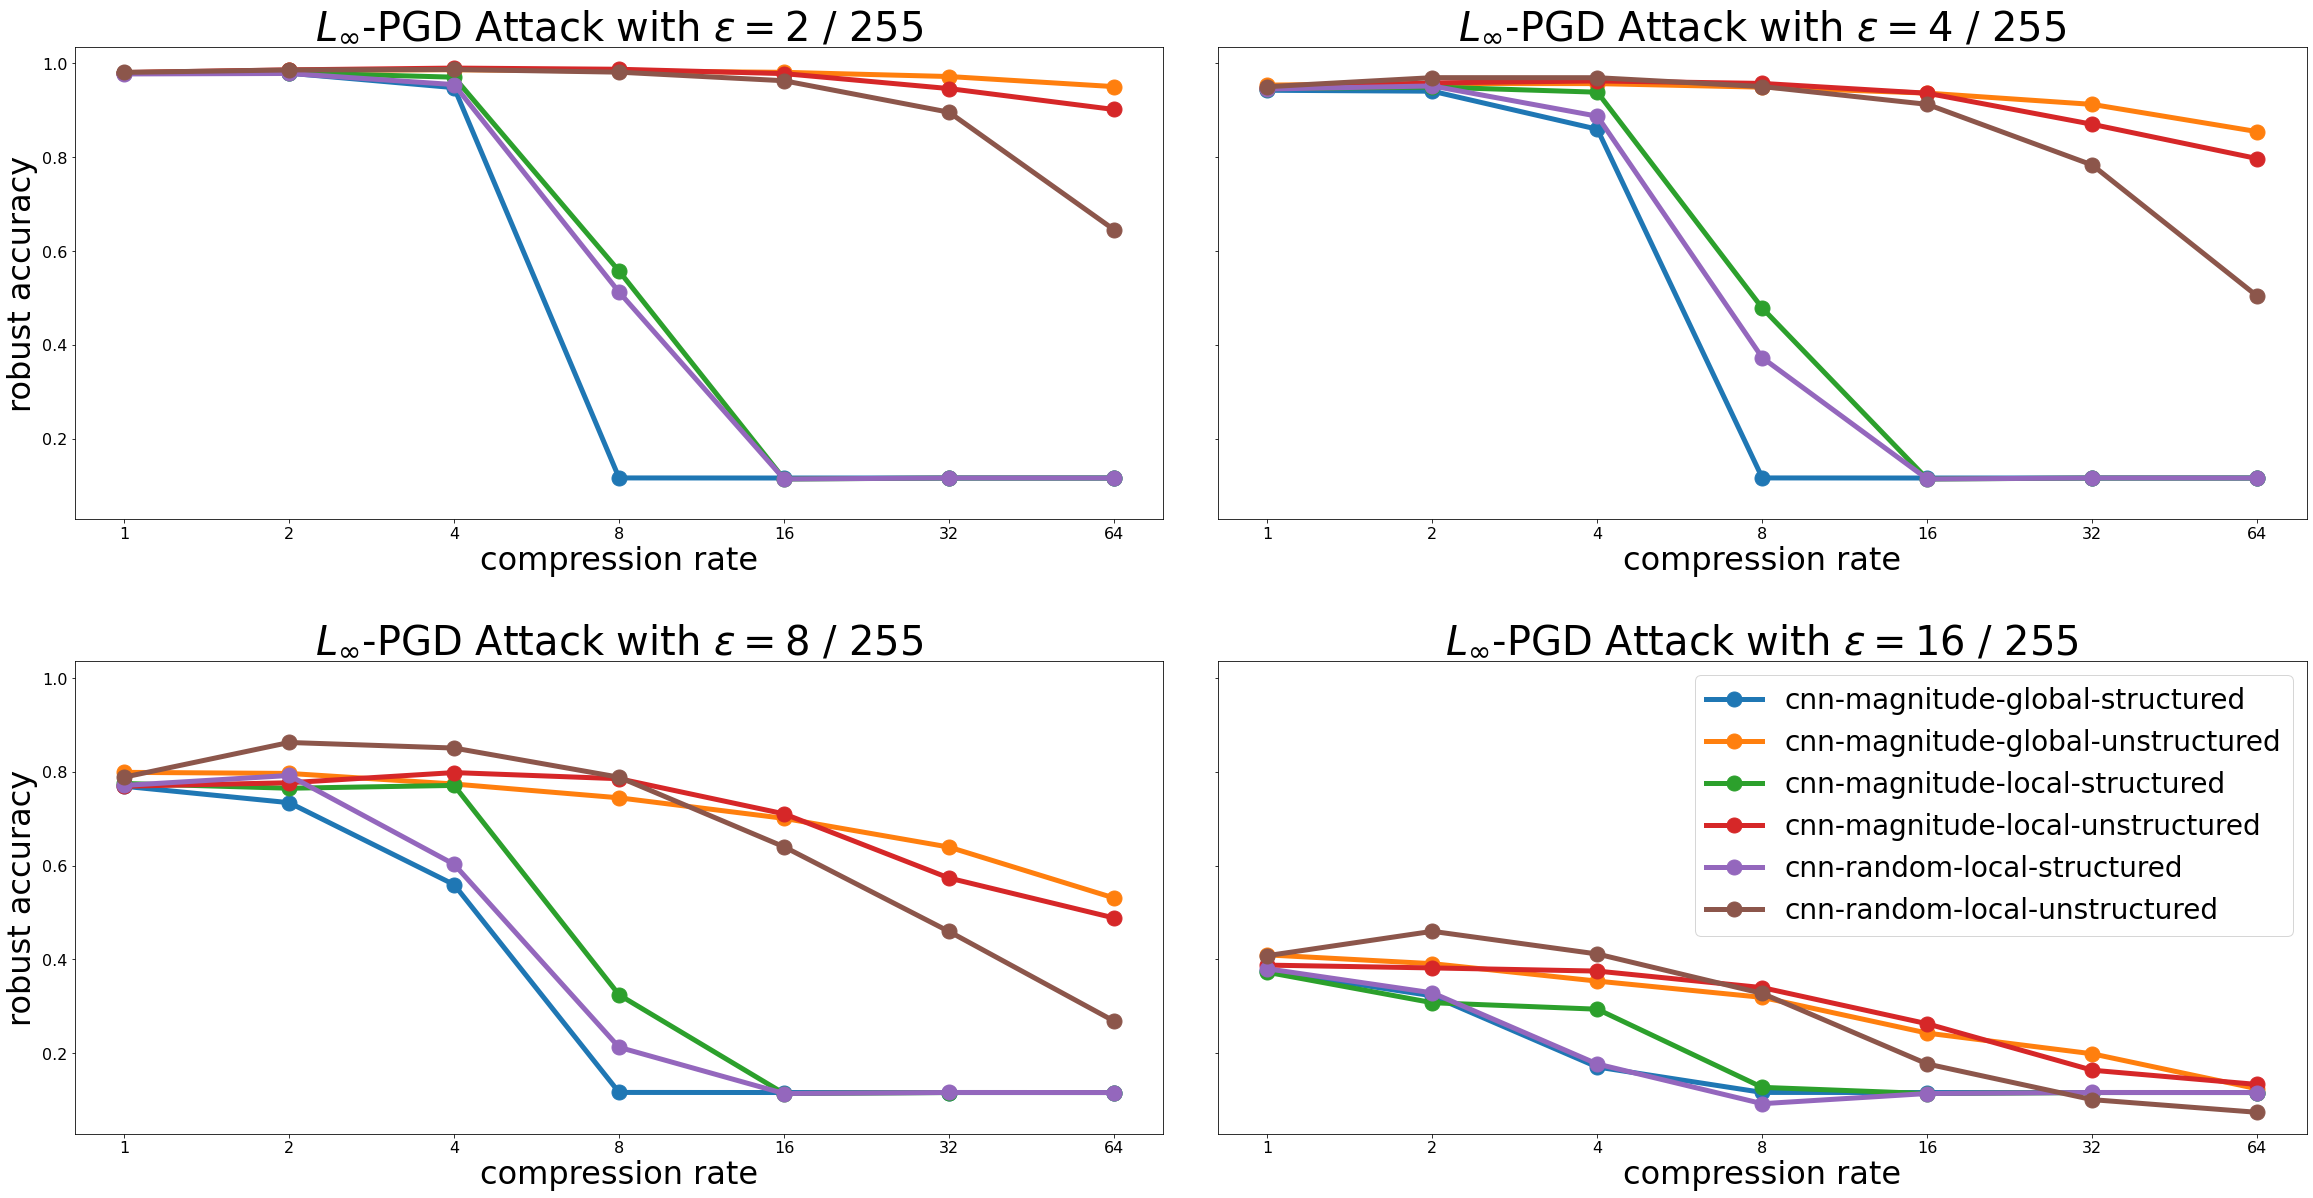

In [17]:
plot_graphic(
    cnn_l_inf_fixed_eps_dfs, 
    title=r'$L_\infty$-PGD Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='cnn_l_inf_fixed_eps',
    infty=True
)

# CNN-l

## $L_0$-Attack

In [18]:
local_eps=[10,30,50,70]
resnet_l0_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l0', architecture='ResNet', l0_eps=eps) for eps in local_eps]
#resnet_l0_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l_inf', architecture='ResNet')

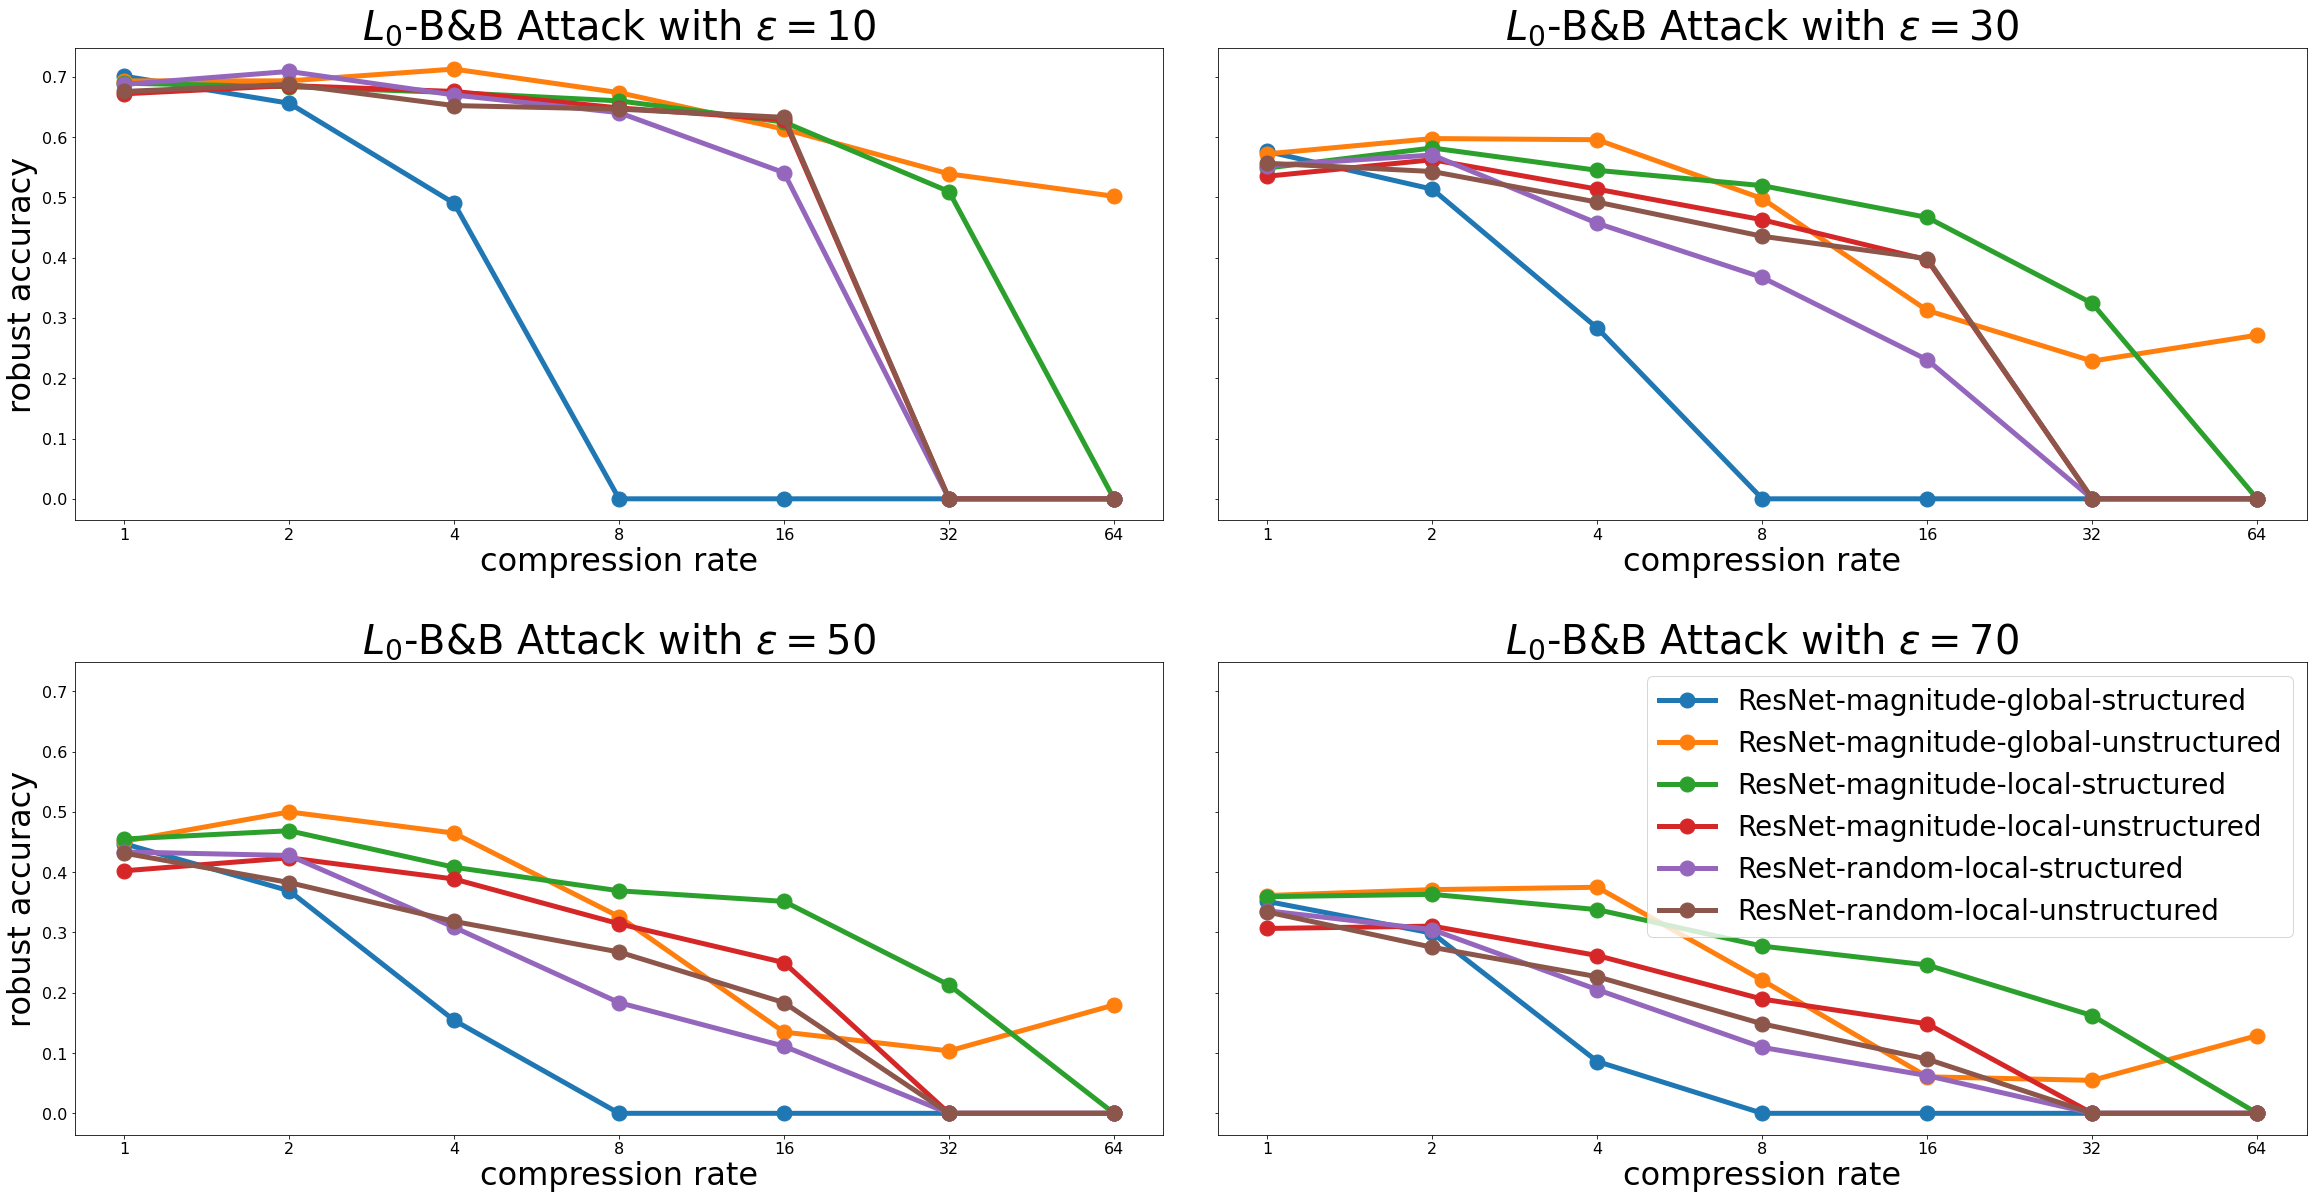

In [19]:
plot_graphic(
    resnet_l0_fixed_eps_dfs, 
    title=r'$L_0$-B&B Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='resnet_l0_fixed_eps'
)
#cnn_l0_fixed_eps_df

In [20]:
calc_diffs_from_first_row(resnet_l0_fixed_eps_dfs[1]).iloc[:5].round(4)

NameError: name 'calc_diffs_from_first_row' is not defined

In [ ]:
resnet_l0_fixed_eps_dfs[1]

## $L_2$-Attack

In [21]:
local_eps= [10,15,20,25]
resnet_l2_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l2', architecture='ResNet', l2_eps=eps) for eps in local_eps]
#resnet_l2_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l2', architecture='ResNet')

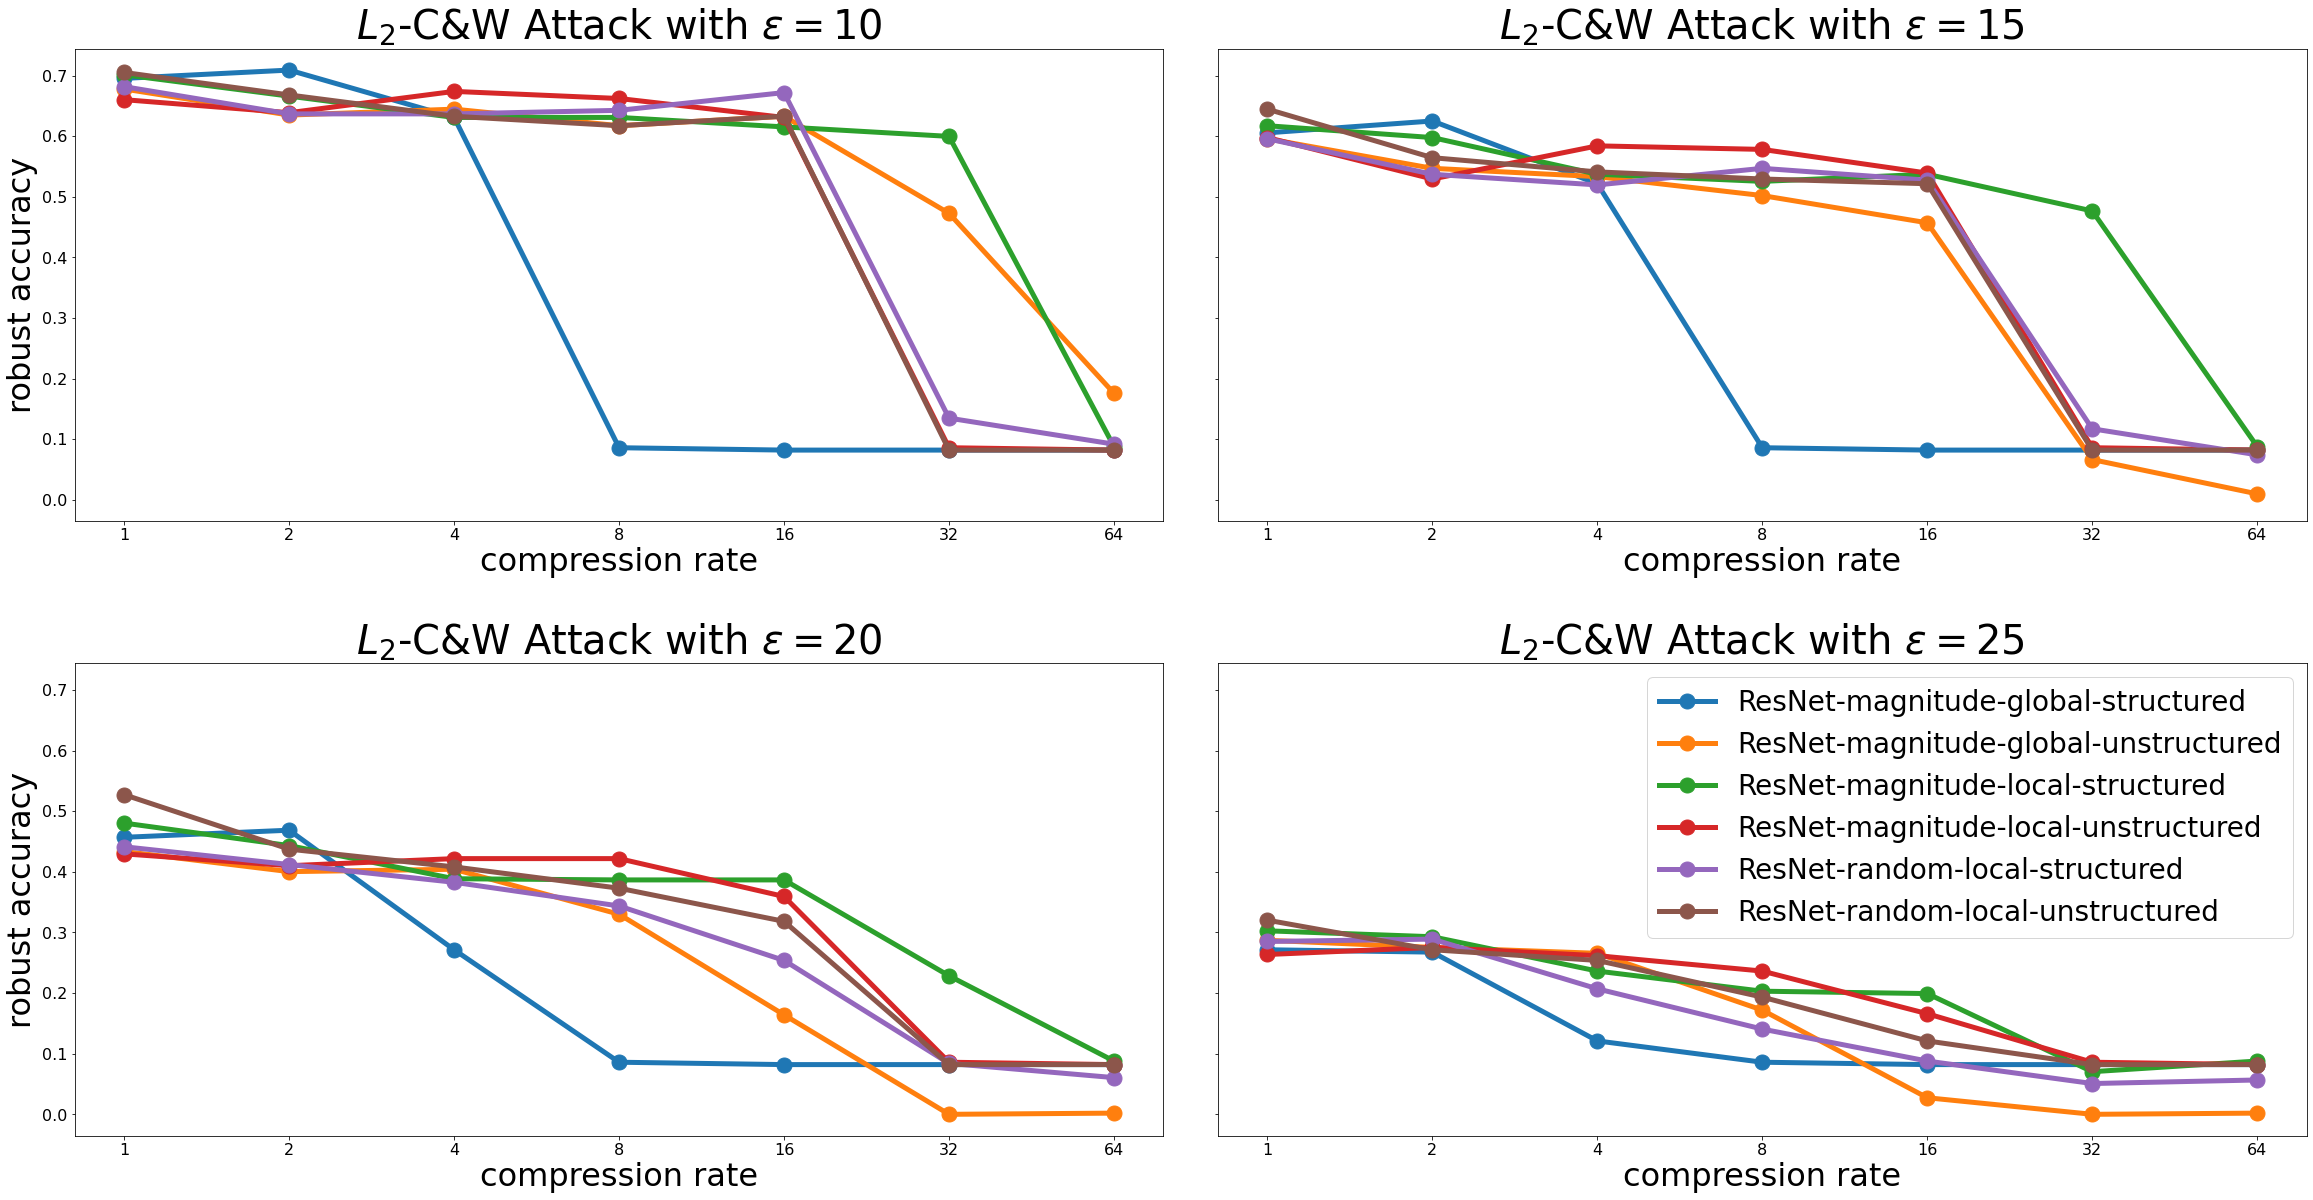

In [22]:
plot_graphic(
    resnet_l2_fixed_eps_dfs, 
    title=r'$L_2$-C&W Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='resnet_l2_fixed_eps'
)
#cnn_l2_fixed_eps_df

## $L_\infty$-Attack

In [23]:
local_eps=[.5,1,2,4]
resnet_l_inf_fixed_eps_dfs = [create_fixed_eps_dataframe(attack_type='l_inf', architecture='ResNet', l_inf_eps=eps) for eps in local_eps]
#resnet_l_inf_fixed_ratio_df = create_fixed_ratio_dataframe(attack_type='l_inf', architecture='ResNet')

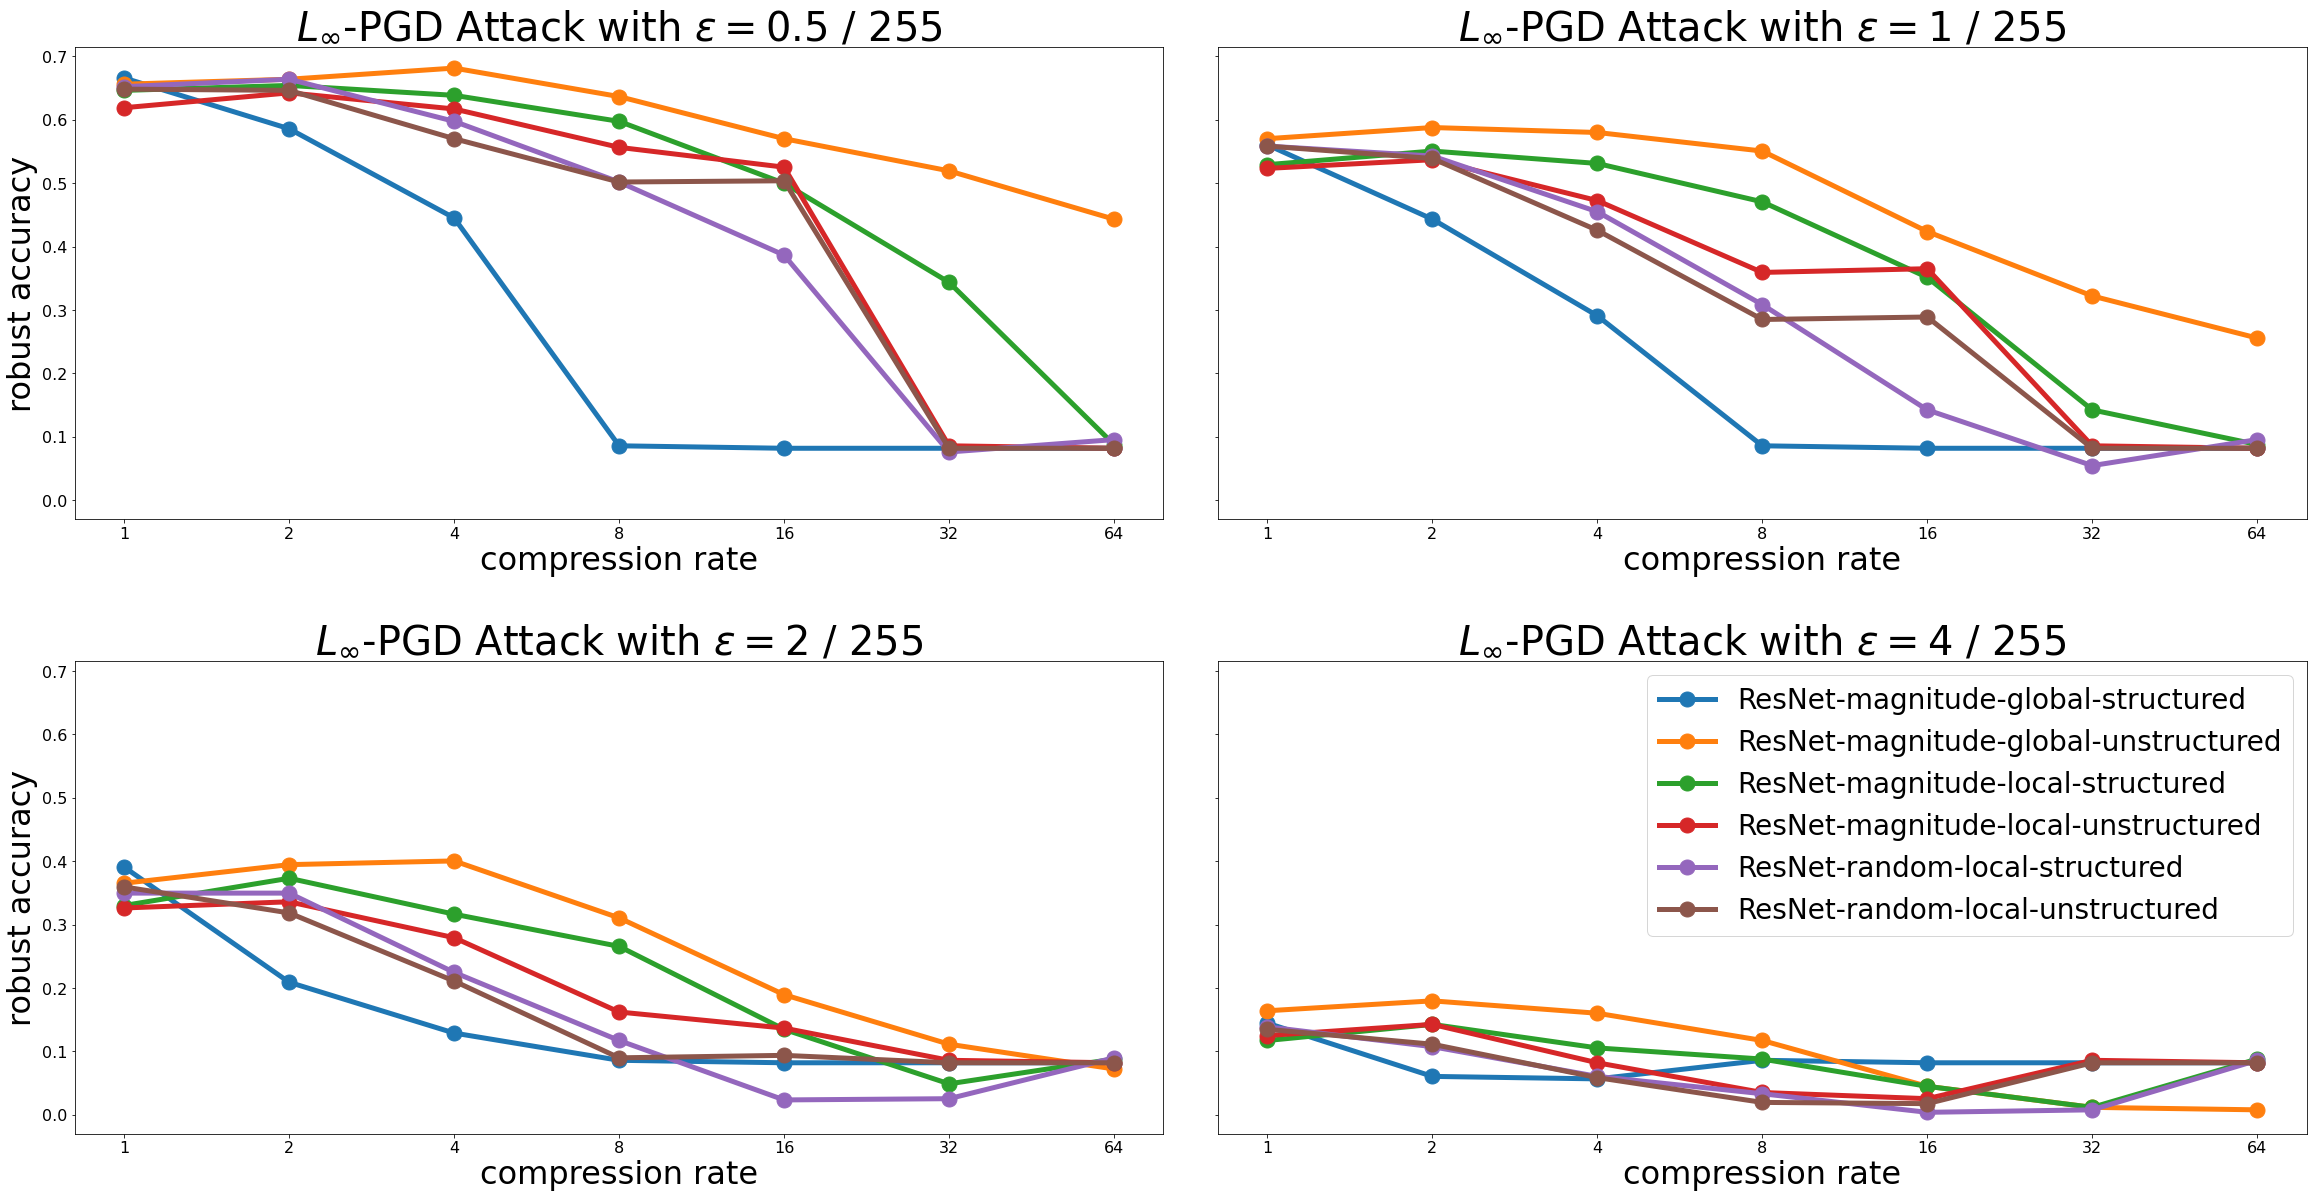

In [24]:
plot_graphic(
    resnet_l_inf_fixed_eps_dfs, 
    title=r'$L_\infty$-PGD Attack with $\epsilon = $',
    x_axis_label='compression rate',
    y_axis_label='robust accuracy',
    eps=local_eps,
    figname='resnet_l_inf_fixed_eps',
    infty=True
)

In [112]:
all_dfs = [

    resnet_l_inf_fixed_eps_dfs,
    resnet_l0_fixed_eps_dfs,
    resnet_l2_fixed_eps_dfs
]

for df in all_dfs:
    test = [calc_diffs_from_first_row(x) for x in df]
    for x in test:
        print(x.max())
        print(x.idxmax())

ResNet-magnitude-global-structured      0.000000
ResNet-magnitude-global-unstructured    0.025391
ResNet-magnitude-local-structured       0.007812
ResNet-magnitude-local-unstructured     0.023438
ResNet-random-local-structured          0.011719
ResNet-random-local-unstructured        0.000000
dtype: float64
ResNet-magnitude-global-structured      1.0
ResNet-magnitude-global-unstructured    4.0
ResNet-magnitude-local-structured       2.0
ResNet-magnitude-local-unstructured     2.0
ResNet-random-local-structured          2.0
ResNet-random-local-unstructured        1.0
dtype: float64
ResNet-magnitude-global-structured      0.000000
ResNet-magnitude-global-unstructured    0.017578
ResNet-magnitude-local-structured       0.021484
ResNet-magnitude-local-unstructured     0.013672
ResNet-random-local-structured          0.000000
ResNet-random-local-unstructured        0.000000
dtype: float64
ResNet-magnitude-global-structured      1.0
ResNet-magnitude-global-unstructured    2.0
ResNet-magnitud

# Average change in robustness over attacks and $\epsilon$ values per architecture and pruning method

In [70]:
def calc_mean_unpruned_vals(dfs):
    for i in range(len(dfs)):
        mean = dfs[i].iloc[0].mean()
        for j in range(len(dfs[i].iloc[0])):
            dfs[i].iloc[0][j] = mean
    return dfs


In [71]:
def calc_diffs_from_first_row(df):
    return df.sub(df.iloc[0], axis=1)

def sum_up_and_average_df_element_wise(dfs):
    avg_df = dfs[0]
    for i in range(1, len(dfs)):
        avg_df = avg_df + dfs[i]
    #print(len(dfs))
    return avg_df/len(dfs)

In [136]:
mag_loc_struct = pd.DataFrame()
mag_glob_unstruct = pd.DataFrame()

In [137]:
resnet_dfs = resnet_l0_fixed_eps_dfs+resnet_l2_fixed_eps_dfs+resnet_l_inf_fixed_eps_dfs
resnet_diffs = [calc_diffs_from_first_row(resnet_dfs[i]) for i in range(len(resnet_dfs))]
res_df = sum_up_and_average_df_element_wise(resnet_diffs)
(res_df).round(4)
mag_loc_struct['ResNet'] = (res_df).round(4)['ResNet-magnitude-local-structured']
mag_glob_unstruct['ResNet'] = (res_df).round(4)['ResNet-magnitude-global-unstructured']

12


In [138]:
cnn_s_dfs = cnn_l0_fixed_eps_dfs+cnn_l2_fixed_eps_dfs+cnn_l_inf_fixed_eps_dfs
cnn_s_diffs = [calc_diffs_from_first_row(cnn_s_dfs[i]) for i in range(len(cnn_s_dfs))]
cnn_df = sum_up_and_average_df_element_wise(cnn_s_diffs)
(cnn_df).round(4)
mag_loc_struct['CNN'] = (cnn_df).round(4)['cnn-magnitude-local-structured']
mag_glob_unstruct['CNN'] = (cnn_df).round(4)['cnn-magnitude-global-unstructured']

12


In [139]:
mlp_dfs = mlp_l0_fixed_eps_dfs+mlp_l2_fixed_eps_dfs+mlp_l_inf_fixed_eps_dfs
mlp_diffs = [calc_diffs_from_first_row(mlp_dfs[i]) for i in range(len(mlp_dfs))]
mlp_df = sum_up_and_average_df_element_wise(mlp_diffs)
(mlp_df).round(4)
mag_loc_struct['MLP'] = (mlp_df).round(4)['MLP-magnitude-local-structured']
mag_glob_unstruct['MLP'] = (mlp_df).round(4)['MLP-magnitude-global-unstructured']

12


In [140]:
mag_loc_struct

ResNet     CNN     MLP
1.0   0.0000  0.0000  0.0000
2.0   0.0034 -0.0861 -0.0888
4.0  -0.0356 -0.1289 -0.2673
8.0  -0.0653 -0.4360 -0.3697
16.0 -0.1099 -0.5583 -0.4830
32.0 -0.2205 -0.5568 -0.5869
64.0 -0.4229 -0.5568 -0.5733

In [141]:
mag_glob_unstruct

ResNet     CNN     MLP
1.0   0.0000  0.0000  0.0000
2.0   0.0015  0.0155  0.0098
4.0  -0.0008 -0.0035 -0.0115
8.0  -0.0728 -0.0270 -0.0534
16.0 -0.1831 -0.0759 -0.1147
32.0 -0.2832 -0.1154 -0.2061
64.0 -0.3148 -0.1889 -0.3010

In [144]:
pd.concat([mag_loc_struct, mag_glob_unstruct], axis=1)

ResNet     CNN     MLP  ResNet     CNN     MLP
1.0   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
2.0   0.0034 -0.0861 -0.0888  0.0015  0.0155  0.0098
4.0  -0.0356 -0.1289 -0.2673 -0.0008 -0.0035 -0.0115
8.0  -0.0653 -0.4360 -0.3697 -0.0728 -0.0270 -0.0534
16.0 -0.1099 -0.5583 -0.4830 -0.1831 -0.0759 -0.1147
32.0 -0.2205 -0.5568 -0.5869 -0.2832 -0.1154 -0.2061
64.0 -0.4229 -0.5568 -0.5733 -0.3148 -0.1889 -0.3010

In [28]:
def get_clean_accs_df(architecture='ResNet'):
    all_clean_accs = {}
    if architecture=='ResNet':
        keys = list(res.keys())[12:]
    if architecture=='MLP':
        keys = list(res.keys())[6:12]
    if architecture=='CNN':
        keys = list(res.keys())[:6]
    for key in keys:
        method_results = res[key]

        ratios = method_results['pruning_ratio'].unique()
        avg_clean_acc = {}
        for ratio in ratios:
            frac_ratio = 1/(1-ratio)
            a = method_results.loc[method_results['pruning_ratio'] == ratio]
            avg_clean_acc[frac_ratio] = a['accuracy'].mean()
        all_clean_accs[key] = pd.Series(avg_clean_acc, )#index=[0])
    return pd.concat(all_clean_accs, axis=1, sort=False)

In [29]:
def plot_clean_accuracy(clean_acc_df, x_axis_label = 'compression ratio', y_axis_label = 'accuracy', title='Clean Accuracies', figname='unnamed.png'):


    fig, ax = plt.subplots(ncols=1, nrows=1, sharey=True, gridspec_kw={'wspace': 0.05, 'hspace':.3})
    #axes = axes.flatten()

    x = clean_acc_df.plot(marker='o', markersize=15,figsize=(40,10), fontsize=16, linewidth=5,ax=ax)
    x.set_title(title, fontsize=40)
    x.set_xscale('log')
    x.set_xticks([1,2,4,8,16,32,64])
    x.set_xticklabels([1,2,4,8,16,32,64] )
    x.minorticks_off()
    x.set_xlabel(x_axis_label, fontsize=32)
    x.set_ylabel(y_axis_label, fontsize=32)

    x.legend(loc=3,prop={'size': 28})

        #fig.tight_layout()
    fig.savefig(f'./graphics/{figname}.png', dpi=72, bbox_inches='tight')

# Clean Accuracy - MLP

MLP-magnitude-global-structured  MLP-magnitude-global-unstructured  \
1.0                           0.97506                            0.97614   
2.0                           0.11350                            0.97995   
4.0                           0.11350                            0.98192   
8.0                           0.11350                            0.98167   
16.0                          0.11350                            0.98134   
32.0                          0.11350                            0.97756   
64.0                          0.11350                            0.96883   

      MLP-magnitude-local-structured  MLP-magnitude-local-unstructured  \
1.0                          0.97646                           0.97584   
2.0                          0.97557                           0.98074   
4.0                          0.95767                           0.98178   
8.0                          0.89915                           0.98200   
16.0                         0.69379                           0.97959   
32.0                         0.45365                           0.97099   
64.0                         0.28750                           0.89975   

      MLP-random-local-structured  MLP-random-local-unstructured  
1.0                       0.97680                        0.97589  
2.0                       0.97472                        0.97866  
4.0                       0.96141                        0.97867  
8.0                       0.91209                        0.97405  
16.0                      0.76445                        0.96338  
32.0                      0.52001                        0.92253  
64.0                      0.34347                        0.70652

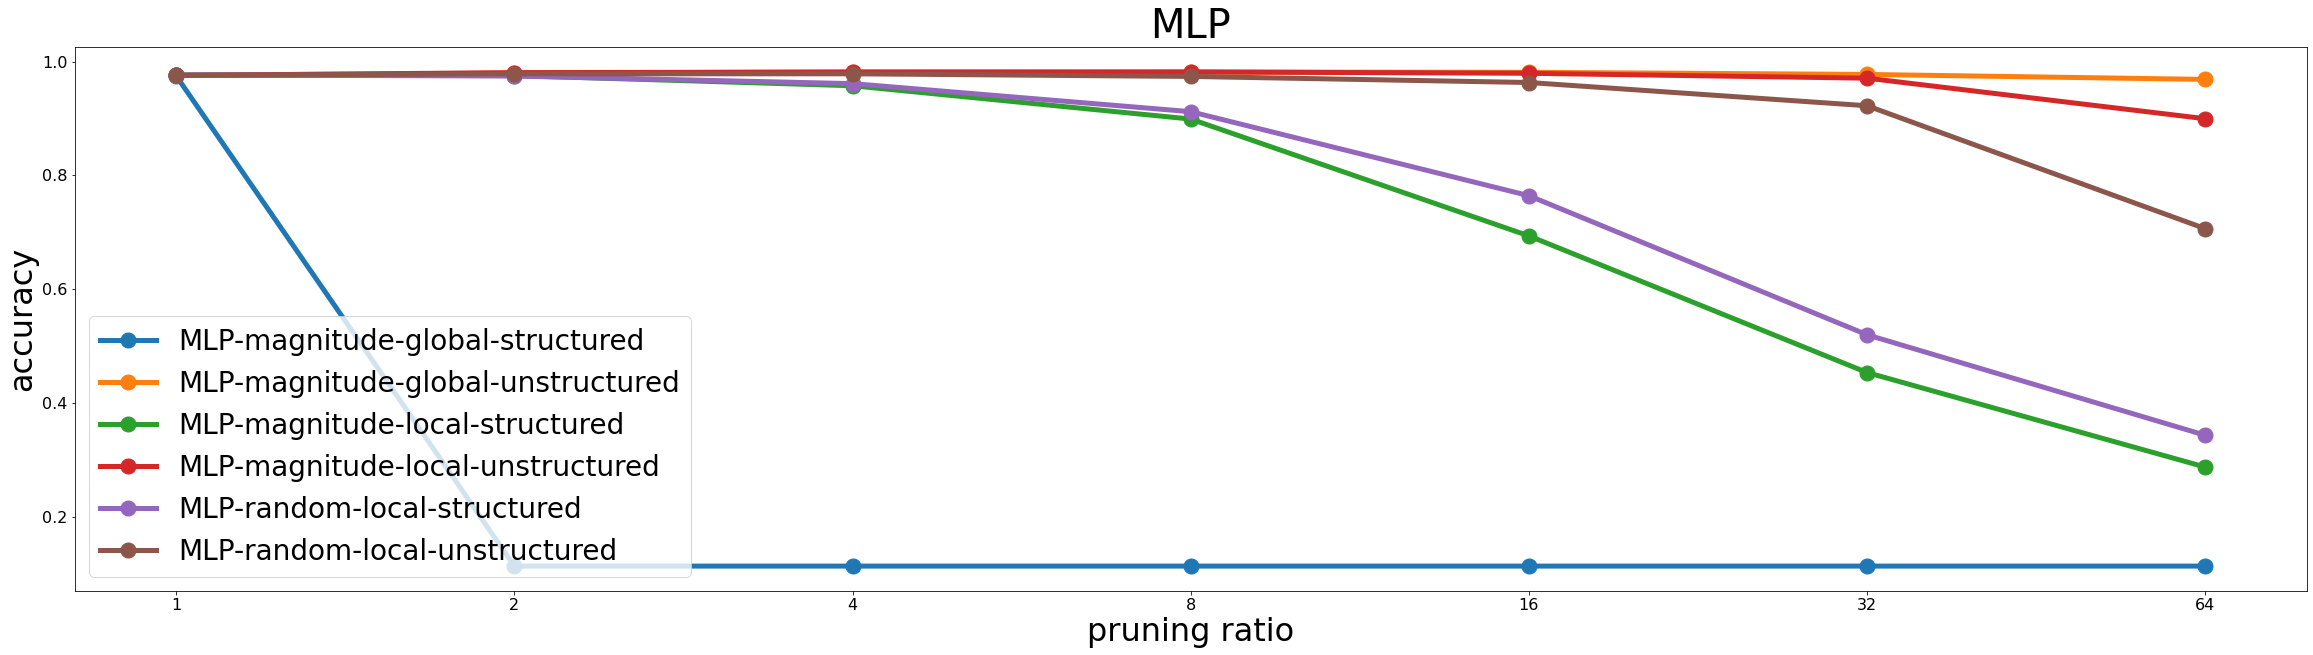

In [30]:
MLP_clean_accs = get_clean_accs_df(architecture='MLP')
plot_clean_accuracy(MLP_clean_accs, figname='MLP-clean-accs', title='MLP')
MLP_clean_accs

# Clean Accuracy - CNN$_s$

cnn-magnitude-global-structured  cnn-magnitude-global-unstructured  \
1.0                           0.98614                            0.98622   
2.0                           0.98526                            0.98745   
4.0                           0.97316                            0.98853   
8.0                           0.11136                            0.98865   
16.0                          0.11350                            0.98759   
32.0                          0.11350                            0.98462   
64.0                          0.11350                            0.97673   

      cnn-magnitude-local-structured  cnn-magnitude-local-unstructured  \
1.0                          0.98592                           0.98590   
2.0                          0.98547                           0.98798   
4.0                          0.98246                           0.98791   
8.0                          0.59744                           0.98787   
16.0                         0.11118                           0.98445   
32.0                         0.11350                           0.97245   
64.0                         0.11350                           0.94226   

      cnn-random-local-structured  cnn-random-local-unstructured  
1.0                       0.98492                        0.98577  
2.0                       0.98426                        0.98717  
4.0                       0.97526                        0.98769  
8.0                       0.64145                        0.98493  
16.0                      0.11066                        0.97730  
32.0                      0.11243                        0.93956  
64.0                      0.11350                        0.70556

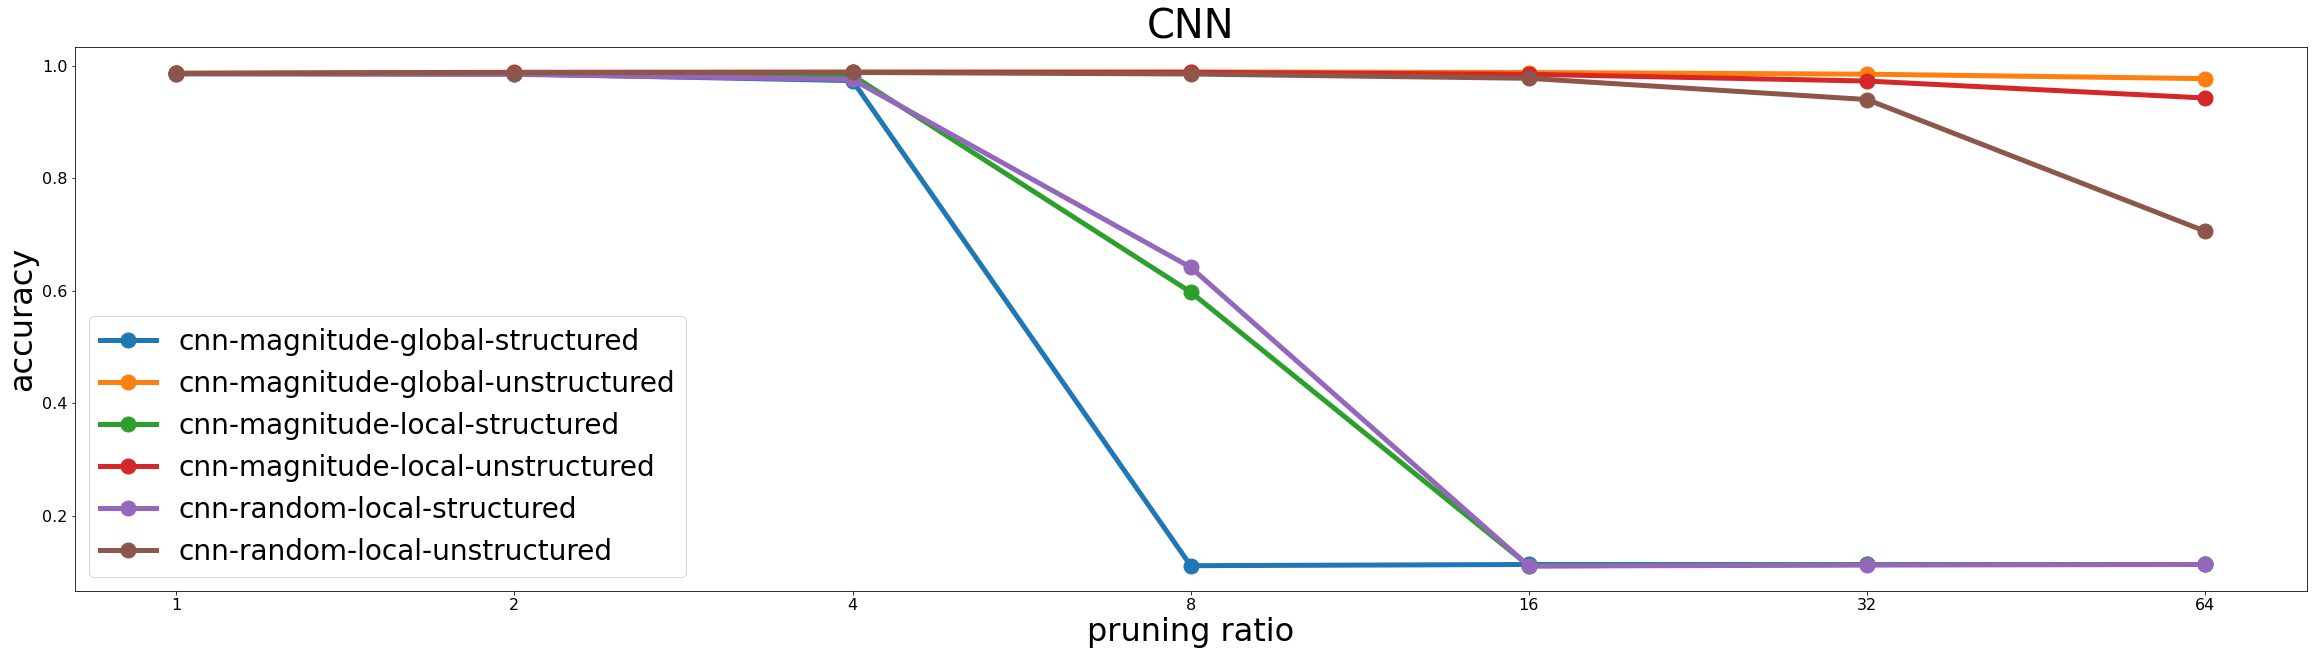

In [31]:
CNN_clean_accs = get_clean_accs_df(architecture='CNN')
plot_clean_accuracy(CNN_clean_accs, figname='CNN-clean-accs', title='CNN')
CNN_clean_accs

# Clean Accuracy - CNN $_L$

ResNet-magnitude-global-structured  \
1.0                             0.814522   
2.0                             0.805478   
4.0                             0.700000   
8.0                             0.096306   
16.0                            0.090955   
32.0                            0.090955   
64.0                            0.090955   

      ResNet-magnitude-global-unstructured  ResNet-magnitude-local-structured  \
1.0                               0.800127                           0.802930   
2.0                               0.799108                           0.806242   
4.0                               0.806242                           0.805605   
8.0                               0.796306                           0.787261   
16.0                              0.785350                           0.766752   
32.0                              0.771210                           0.652611   
64.0                              0.749936                           0.101019   

      ResNet-magnitude-local-unstructured  ResNet-random-local-structured  \
1.0                              0.810318                        0.801019   
2.0                              0.811083                        0.808153   
4.0                              0.809809                        0.813248   
8.0                              0.805223                        0.796560   
16.0                             0.799490                        0.762930   
32.0                             0.096306                        0.148535   
64.0                             0.090955                        0.103057   

      ResNet-random-local-unstructured  
1.0                           0.791847  
2.0                           0.803949  
4.0                           0.803949  
8.0                           0.796433  
16.0                          0.800000  
32.0                          0.090955  
64.0                          0.090955

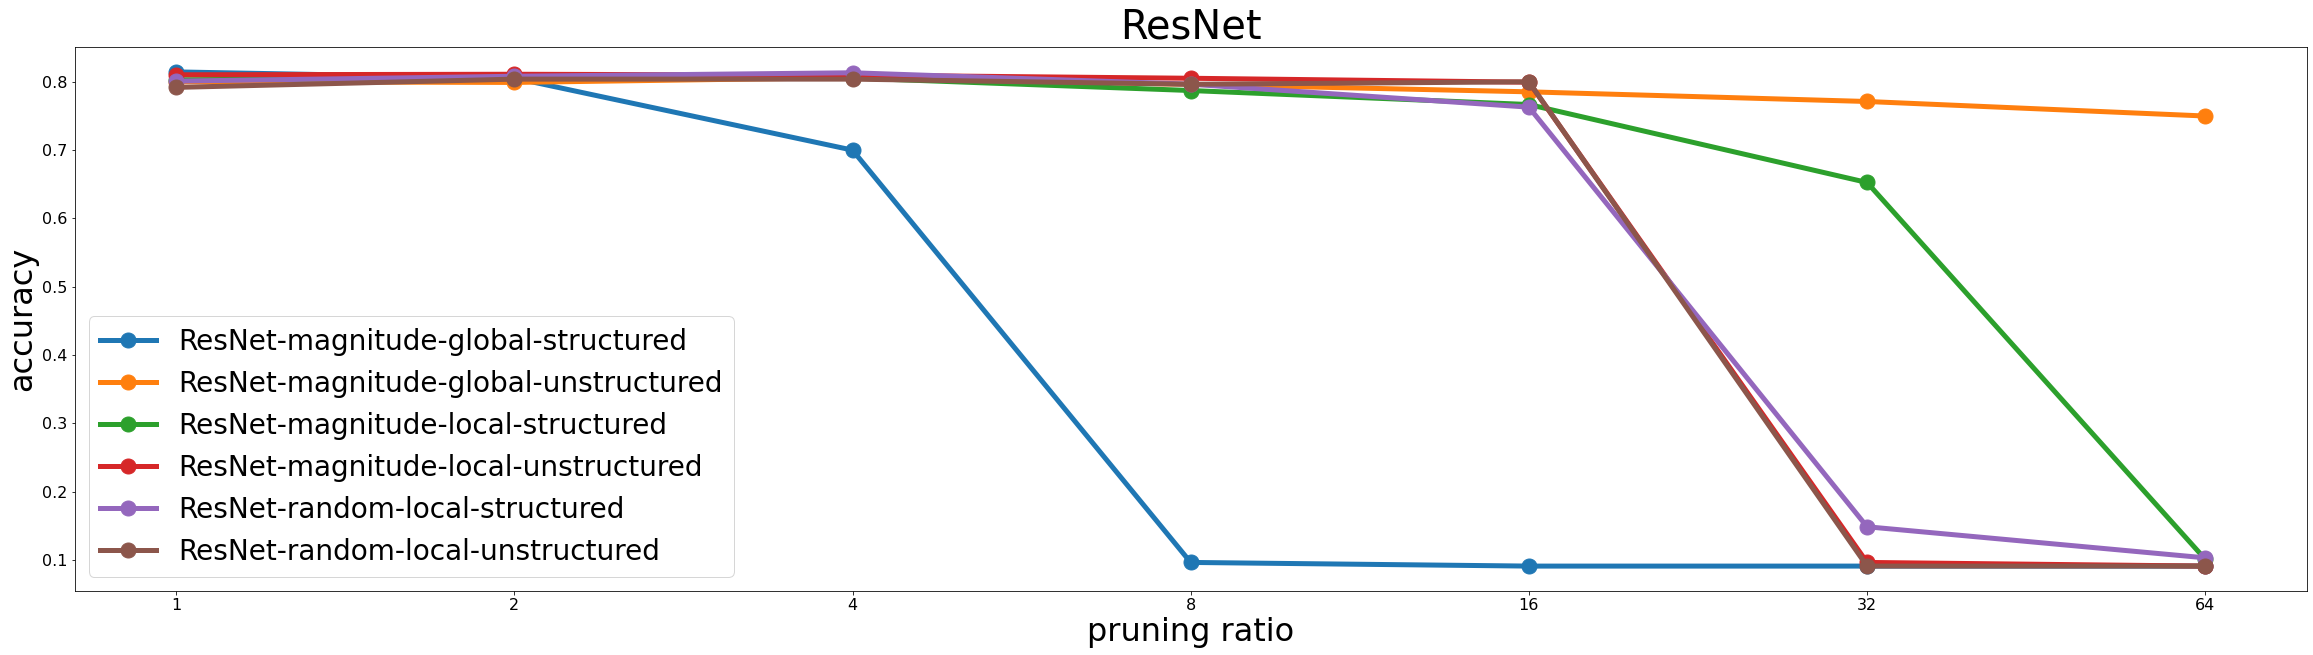

In [32]:
ResNet_clean_accs = get_clean_accs_df(architecture='ResNet')
plot_clean_accuracy(ResNet_clean_accs, figname='ResNet-clean-accs', title='ResNet')
ResNet_clean_accs

# Vary attack

In [155]:
resnet = pd.DataFrame()
resnet[r'$L_0$'] = resnet_l0_fixed_eps_dfs[1]['ResNet-magnitude-global-unstructured']
resnet[r'$L_2$'] = resnet_l2_fixed_eps_dfs[1]['ResNet-magnitude-global-unstructured']
resnet[r'$L_\infty$'] = resnet_l_inf_fixed_eps_dfs[1]['ResNet-magnitude-global-unstructured']

In [156]:
cnn = pd.DataFrame()
cnn[r'L_0'] = cnn_l0_fixed_eps_dfs[2]['cnn-magnitude-global-unstructured']
cnn[r'L_2'] = cnn_l2_fixed_eps_dfs[2]['cnn-magnitude-global-unstructured']
cnn[r'L_\infty'] = cnn_l_inf_fixed_eps_dfs[3]['cnn-magnitude-global-unstructured']

In [157]:
mlp = pd.DataFrame()
mlp[r'L_0'] = mlp_l0_fixed_eps_dfs[2]['MLP-magnitude-global-unstructured']
mlp[r'L_2'] = mlp_l2_fixed_eps_dfs[2]['MLP-magnitude-global-unstructured']
mlp[r'L_\infty'] = mlp_l_inf_fixed_eps_dfs[2]['MLP-magnitude-global-unstructured']

Text(0, 0.5, 'robust accuracy')

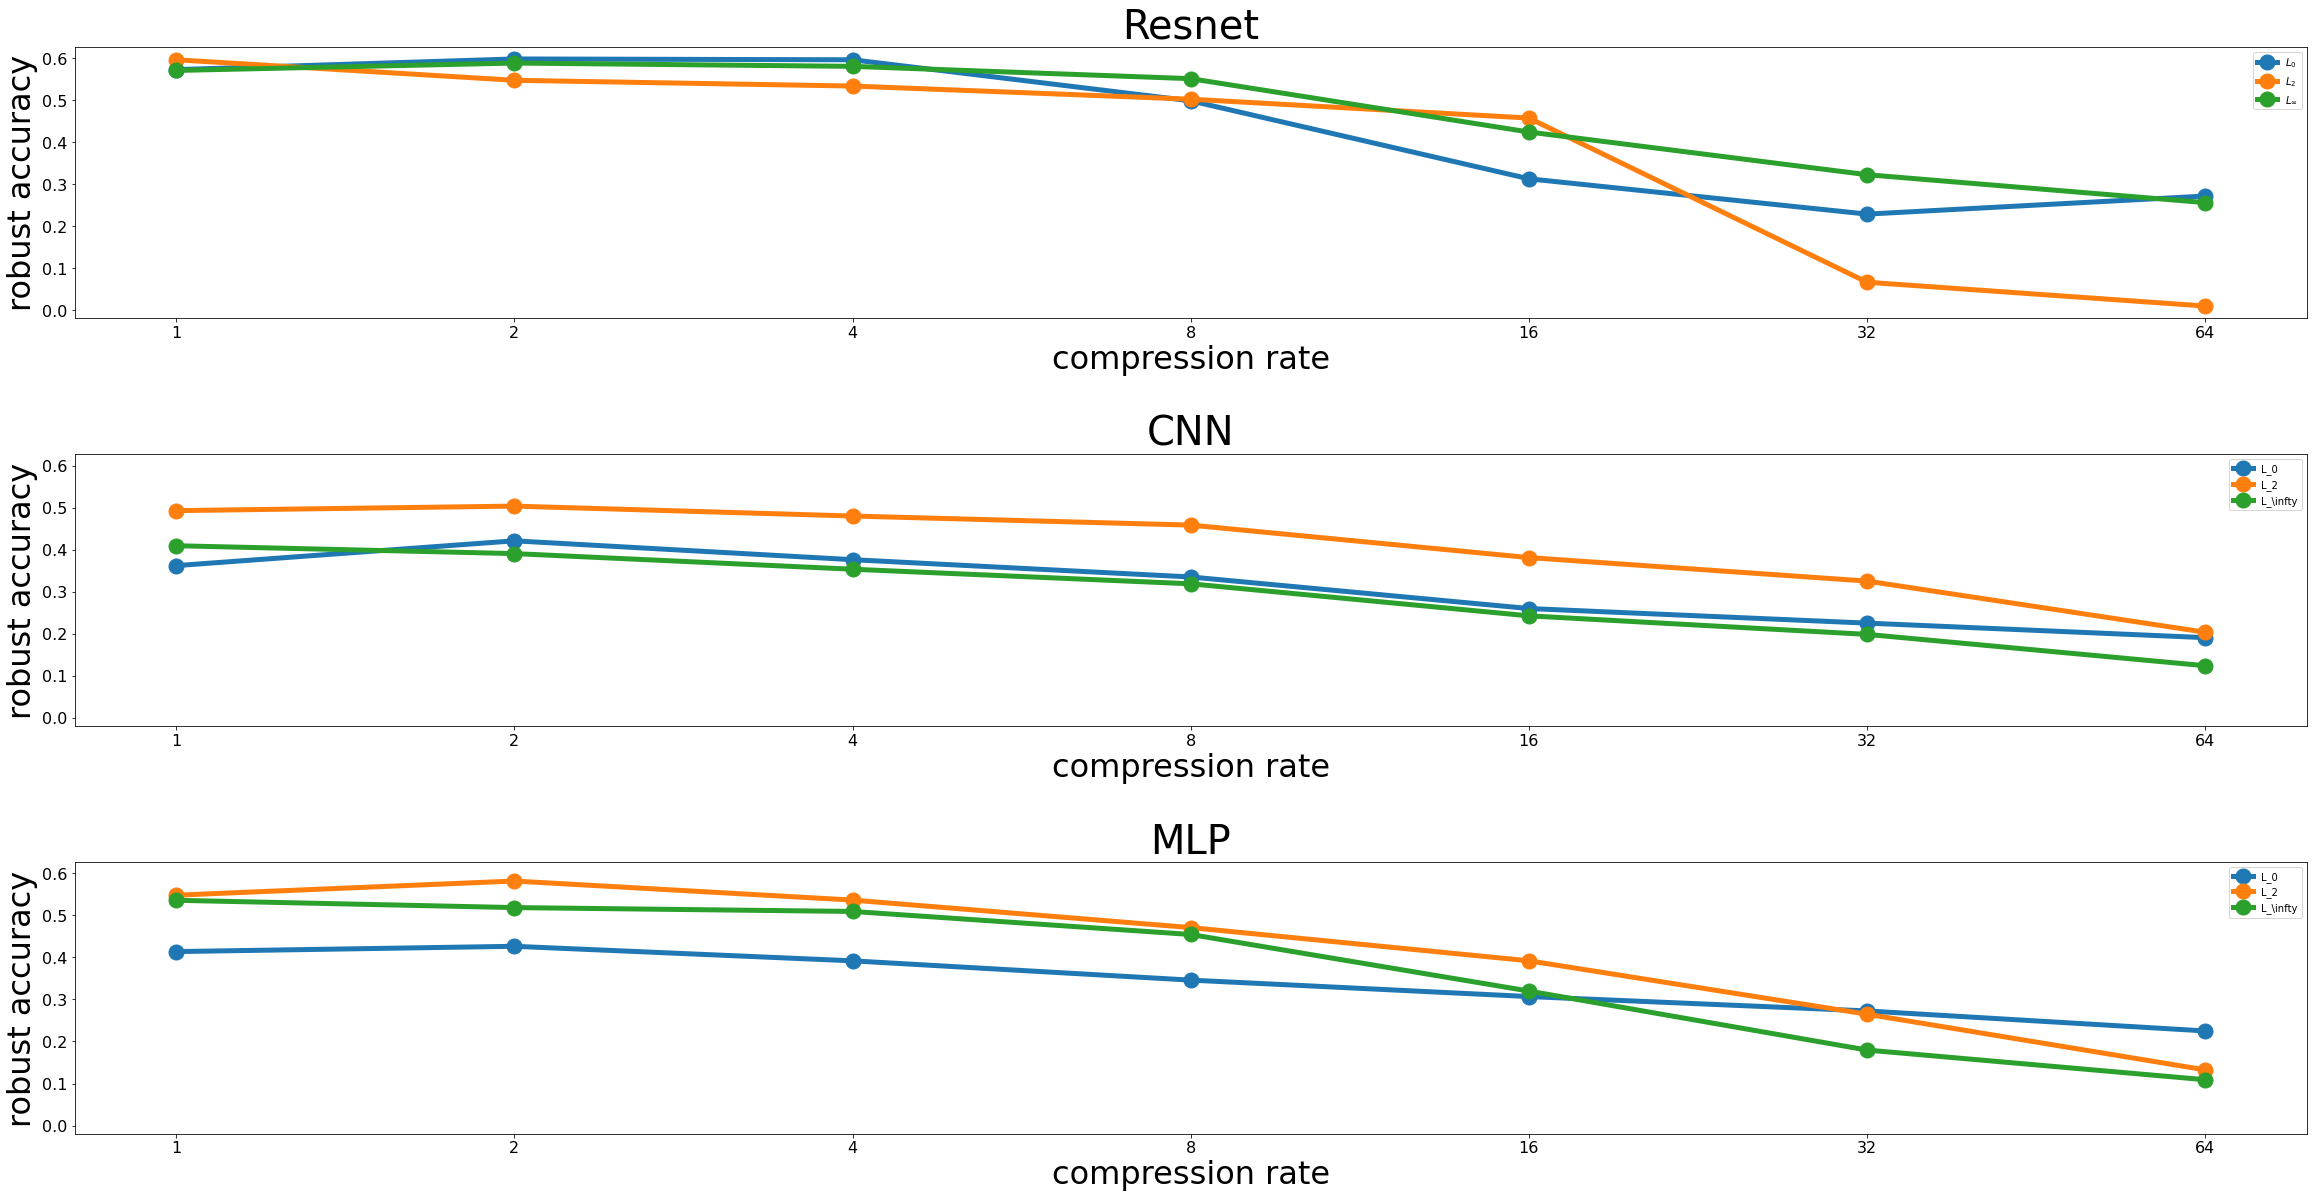

In [158]:
x_axis_label = 'compression rate'
y_axis_label = 'robust accuracy'
        
fig, axes = plt.subplots(ncols=1, nrows=3, sharey=True, gridspec_kw={'wspace': 0.05, 'hspace':.5})
#axes = axes.flatten()
    

x = resnet.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[0])
x.set_title('Resnet', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)

x = cnn.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[1])
x.set_title('CNN', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)


x = mlp.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[2])
x.set_title('MLP', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)
#fig.savefig(f'./graphics/{figname}.png', dpi=72, bbox_inches='tight')

In [40]:
test = [cnn_l0_fixed_eps_dfs[1],
cnn_l2_fixed_eps_dfs[1],
cnn_l_inf_fixed_eps_dfs[1]]

In [150]:
l0 = pd.DataFrame()
l0[r'MLP'] = mlp_l0_fixed_eps_dfs[2]['MLP-magnitude-global-unstructured']
l0[r'CNN'] = cnn_l0_fixed_eps_dfs[2]['cnn-magnitude-global-unstructured']
l0[r'ResNet'] = resnet_l0_fixed_eps_dfs[2]['ResNet-magnitude-global-unstructured']# Vary architecture

In [151]:
l2 = pd.DataFrame()
l2[r'MLP'] = mlp_l2_fixed_eps_dfs[2]['MLP-magnitude-global-unstructured']
l2[r'CNN'] = cnn_l2_fixed_eps_dfs[2]['cnn-magnitude-global-unstructured']
l2[r'ResNet'] = resnet_l2_fixed_eps_dfs[2]['ResNet-magnitude-global-unstructured']# Vary architecture

In [152]:
l_inf = pd.DataFrame()
l_inf[r'MLP'] = mlp_l_inf_fixed_eps_dfs[2]['MLP-magnitude-global-unstructured']
l_inf[r'CNN'] = cnn_l_inf_fixed_eps_dfs[2]['cnn-magnitude-global-unstructured']
l_inf[r'ResNet'] = resnet_l_inf_fixed_eps_dfs[2]['ResNet-magnitude-global-unstructured']# Vary architecture

In [153]:
l2

MLP     CNN    ResNet
1.0   0.5481  0.4930  0.433594
2.0   0.5818  0.5038  0.400391
4.0   0.5364  0.4802  0.404297
8.0   0.4710  0.4586  0.330078
16.0  0.3920  0.3813  0.164062
32.0  0.2649  0.3254  0.000000
64.0  0.1324  0.2037  0.001953

Text(0, 0.5, 'robust accuracy')

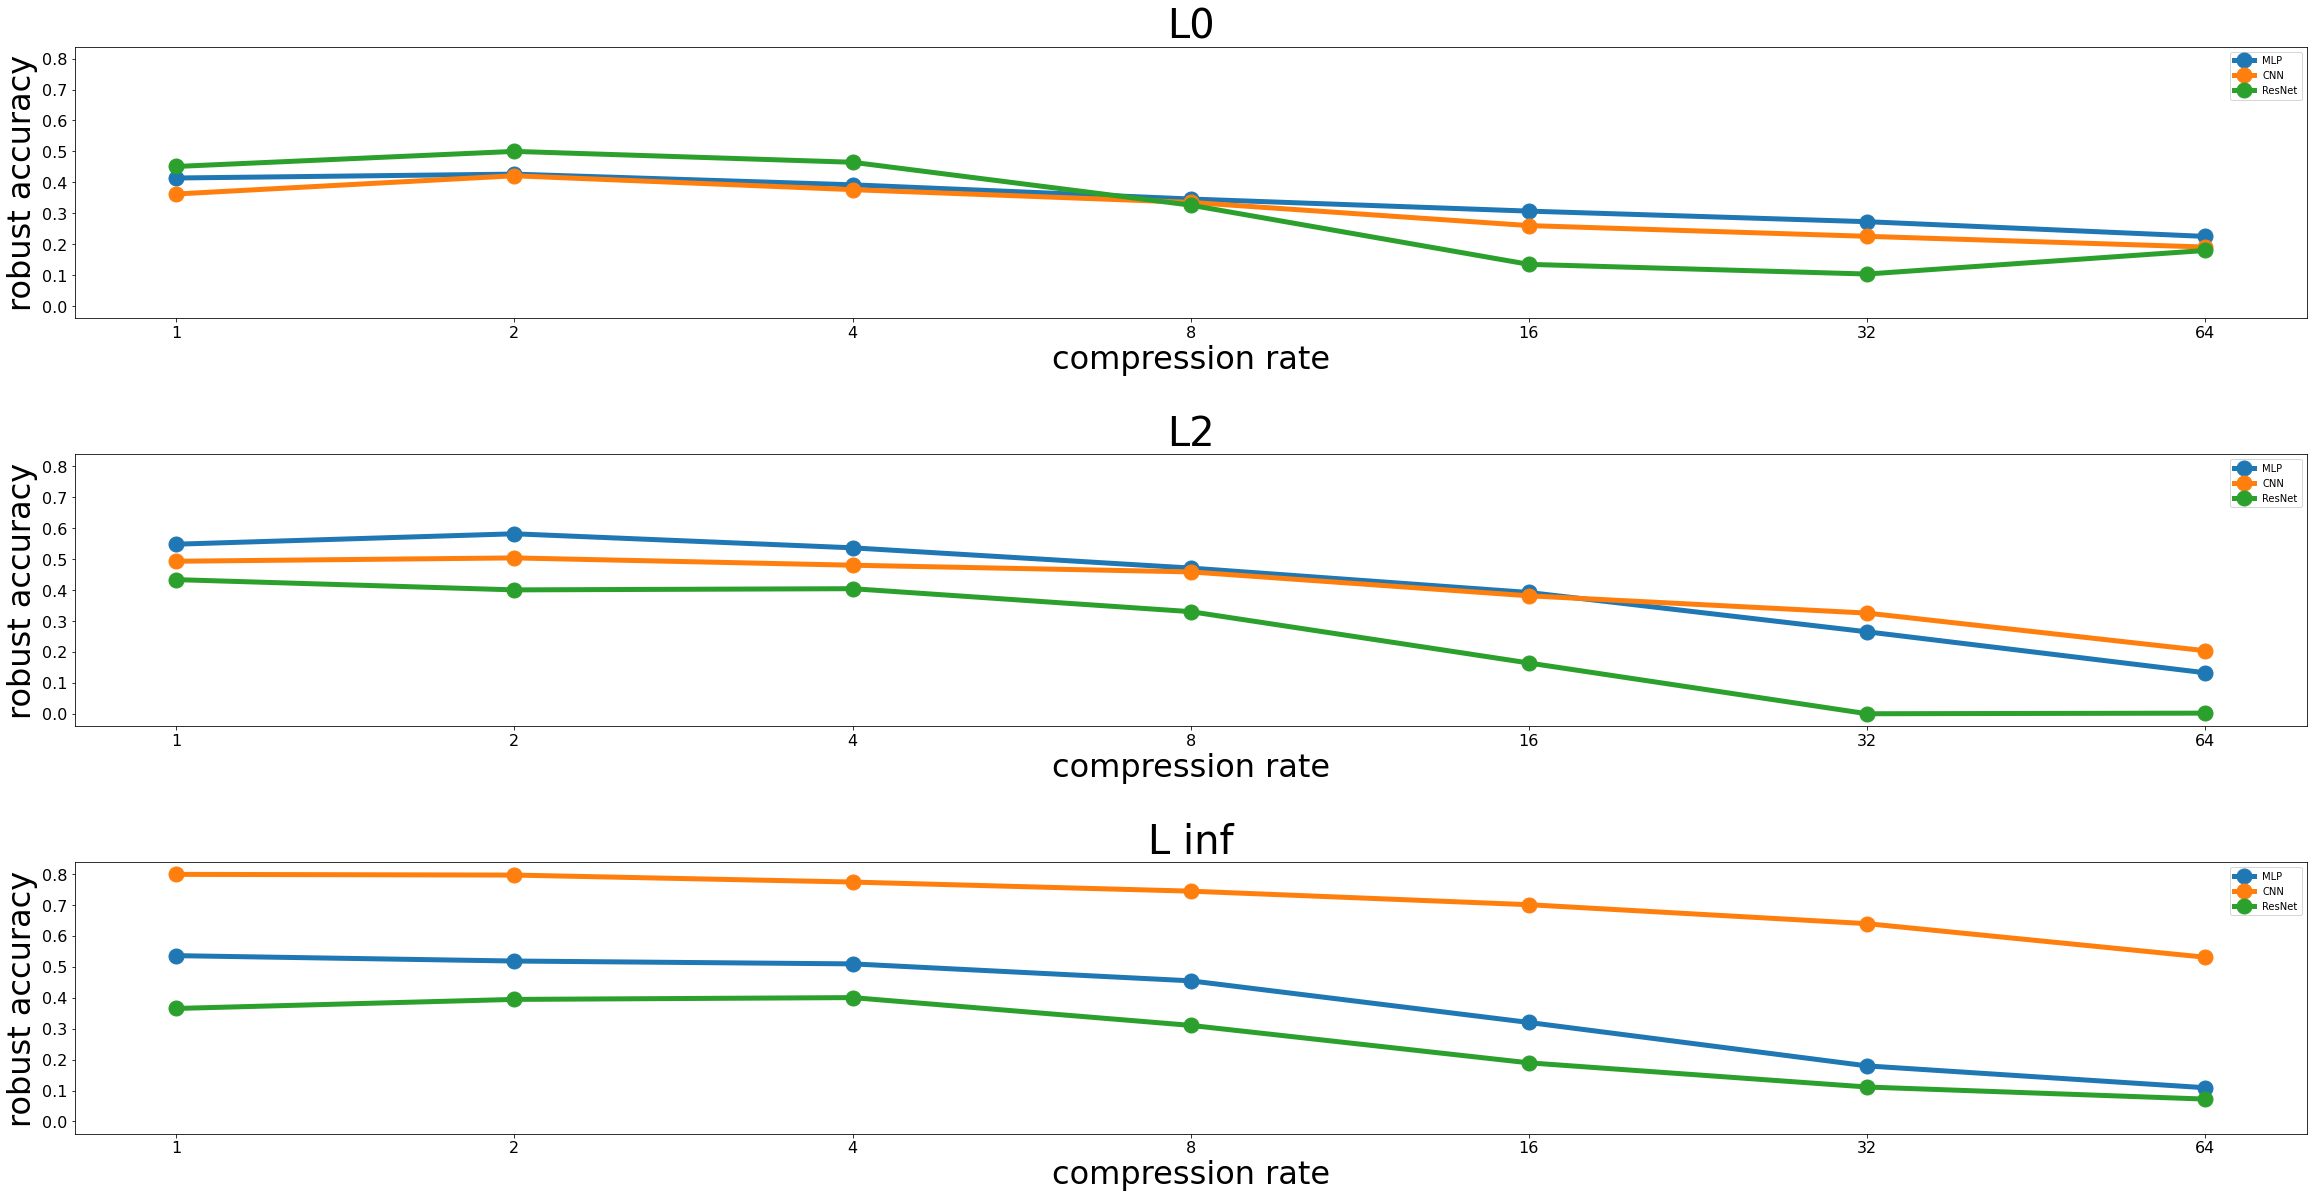

In [154]:
x_axis_label = 'compression rate'
y_axis_label = 'robust accuracy'
        
fig, axes = plt.subplots(ncols=1, nrows=3, sharey=True, gridspec_kw={'wspace': 0.05, 'hspace':.5})
#axes = axes.flatten()
    

x = l0.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[0])
x.set_title('L0', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)

x = l2.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[1])
x.set_title('L2', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)


x = l_inf.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[2])
x.set_title('L inf', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)

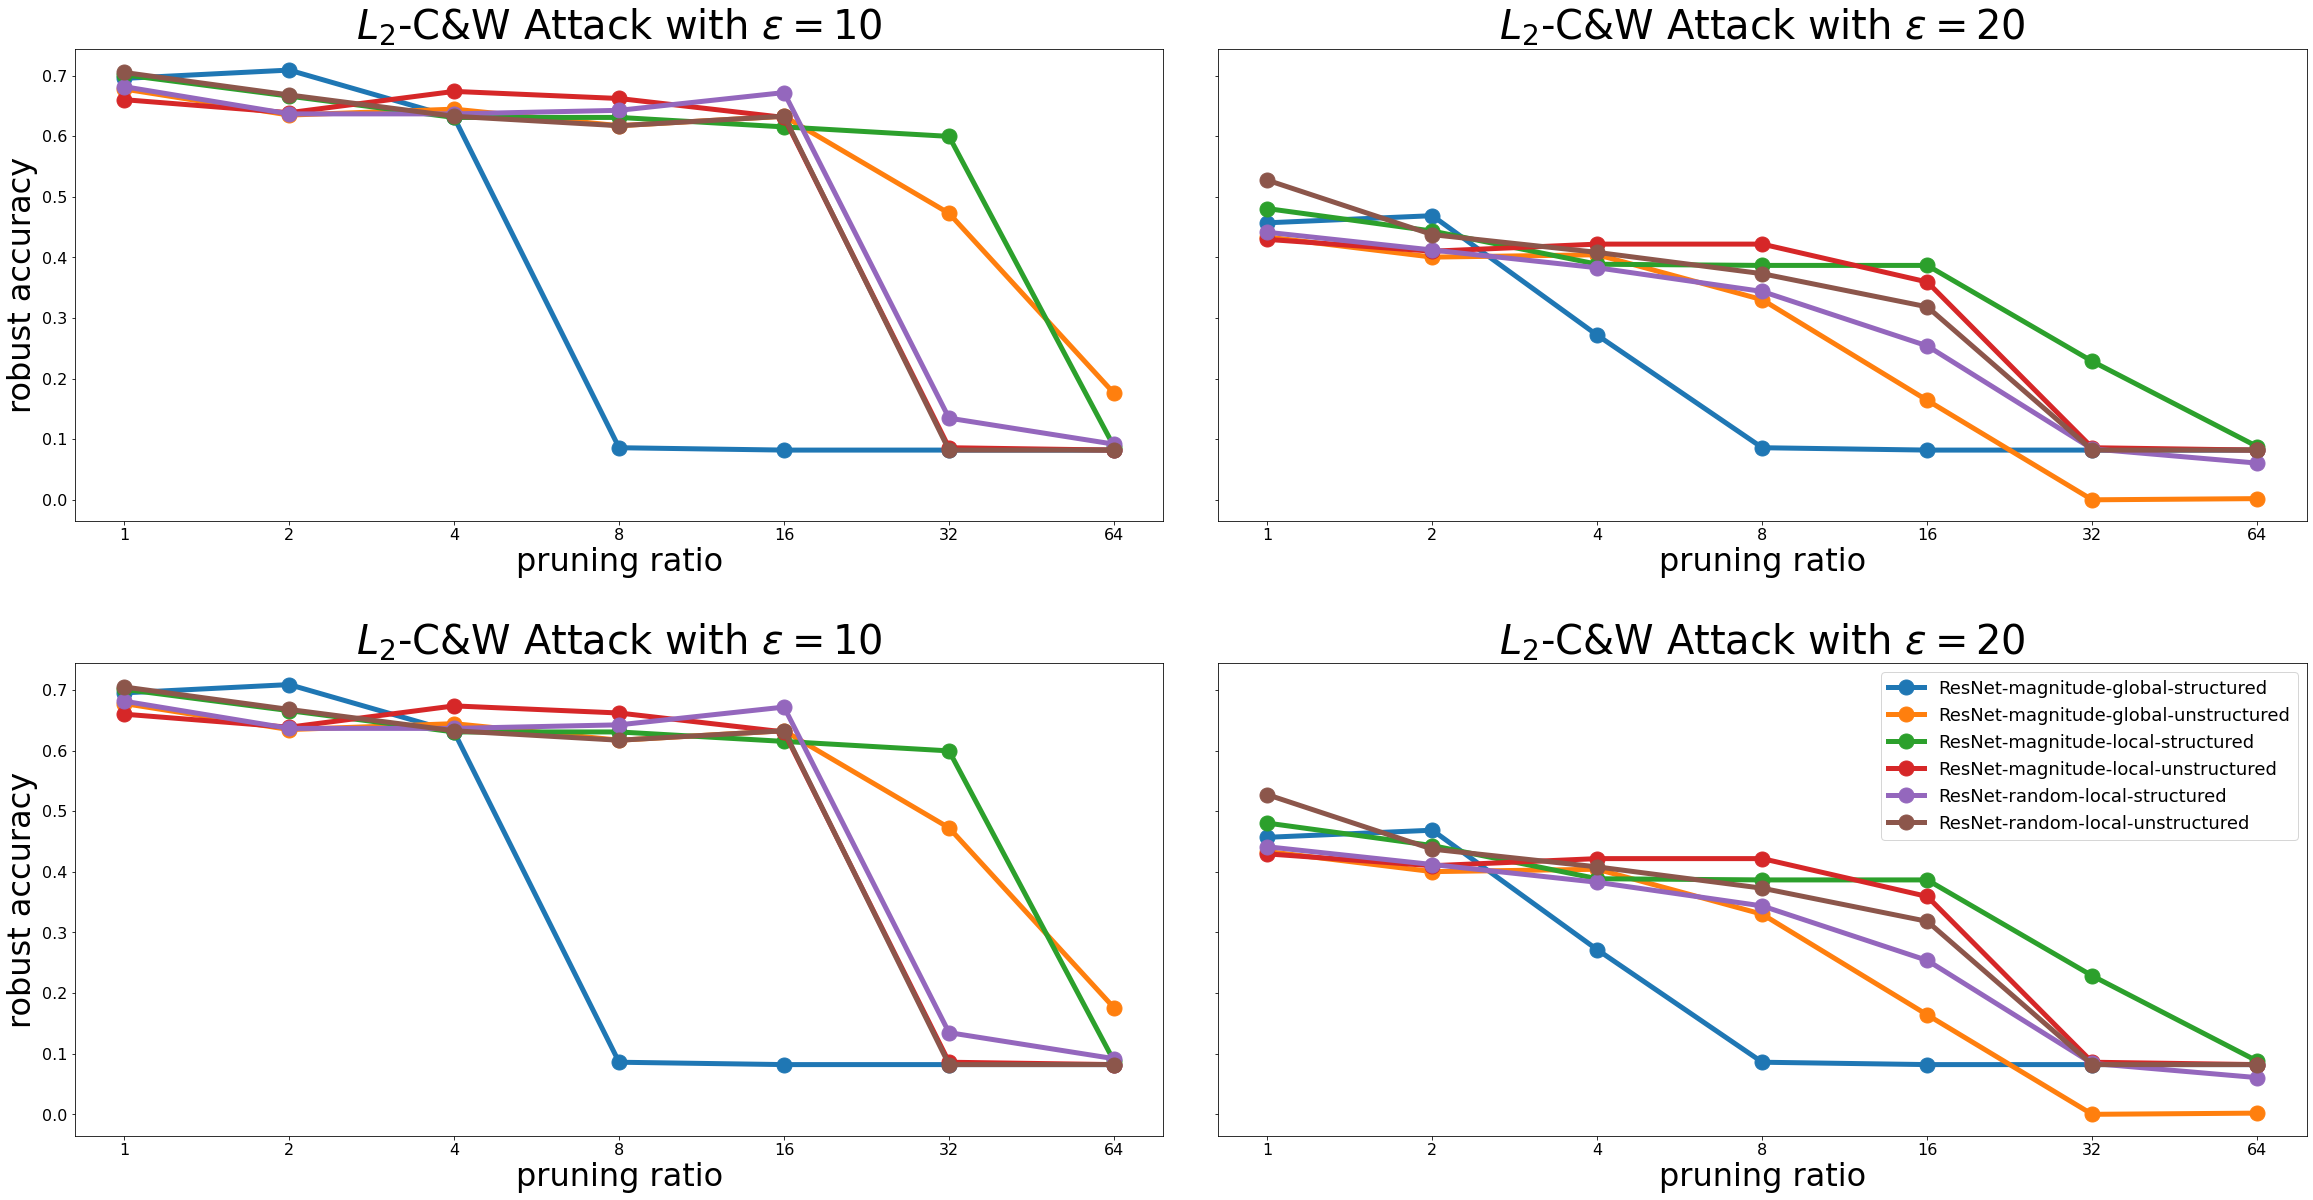

In [177]:
plot_graphic(
    [resnet_l2_fixed_eps_dfs[0], resnet_l2_fixed_eps_dfs[2], resnet_l2_fixed_eps_dfs[0], resnet_l2_fixed_eps_dfs[2]], 
    title=r'$L_2$-C&W Attack with $\epsilon = $',
    x_axis_label='pruning ratio',
    y_axis_label='robust accuracy',
    eps=[10,20,10,20],
    figname='resnet_variance'
)
#cnn_l2_fixed_eps_df

In [62]:
test = pd.DataFrame()

In [66]:
test[r'$B&B-L_0$ attack with $\epsilon = 30$'] = resnet_l0_fixed_eps_dfs[1]['ResNet-magnitude-local-structured']
test[r'$C&W-L_2$ attack with $\epsilon = 15$'] = resnet_l2_fixed_eps_dfs[1]['ResNet-magnitude-local-structured']
test[r'$PGD-L_\infty$ attack with $\epsilon = 1 / 255$'] = resnet_l_inf_fixed_eps_dfs[1]['ResNet-magnitude-local-structured']

In [67]:
test

$B&B-L_0$ attack with $\epsilon = 30$  \
1.0                                0.548828   
2.0                                0.582031   
4.0                                0.544922   
8.0                                0.519531   
16.0                               0.466797   
32.0                               0.324219   
64.0                               0.000000   

      $C&W-L_2$ attack with $\epsilon = 15$  \
1.0                                0.617188   
2.0                                0.597656   
4.0                                0.537109   
8.0                                0.525391   
16.0                               0.537109   
32.0                               0.476562   
64.0                               0.087891   

      $PGD-L_\infty$ attack with $\epsilon = 1 / 255$  
1.0                                          0.529297  
2.0                                          0.550781  
4.0                                          0.531250  
8.0                                          0.470703  
16.0                                         0.351562  
32.0                                         0.142578  
64.0                                         0.087891

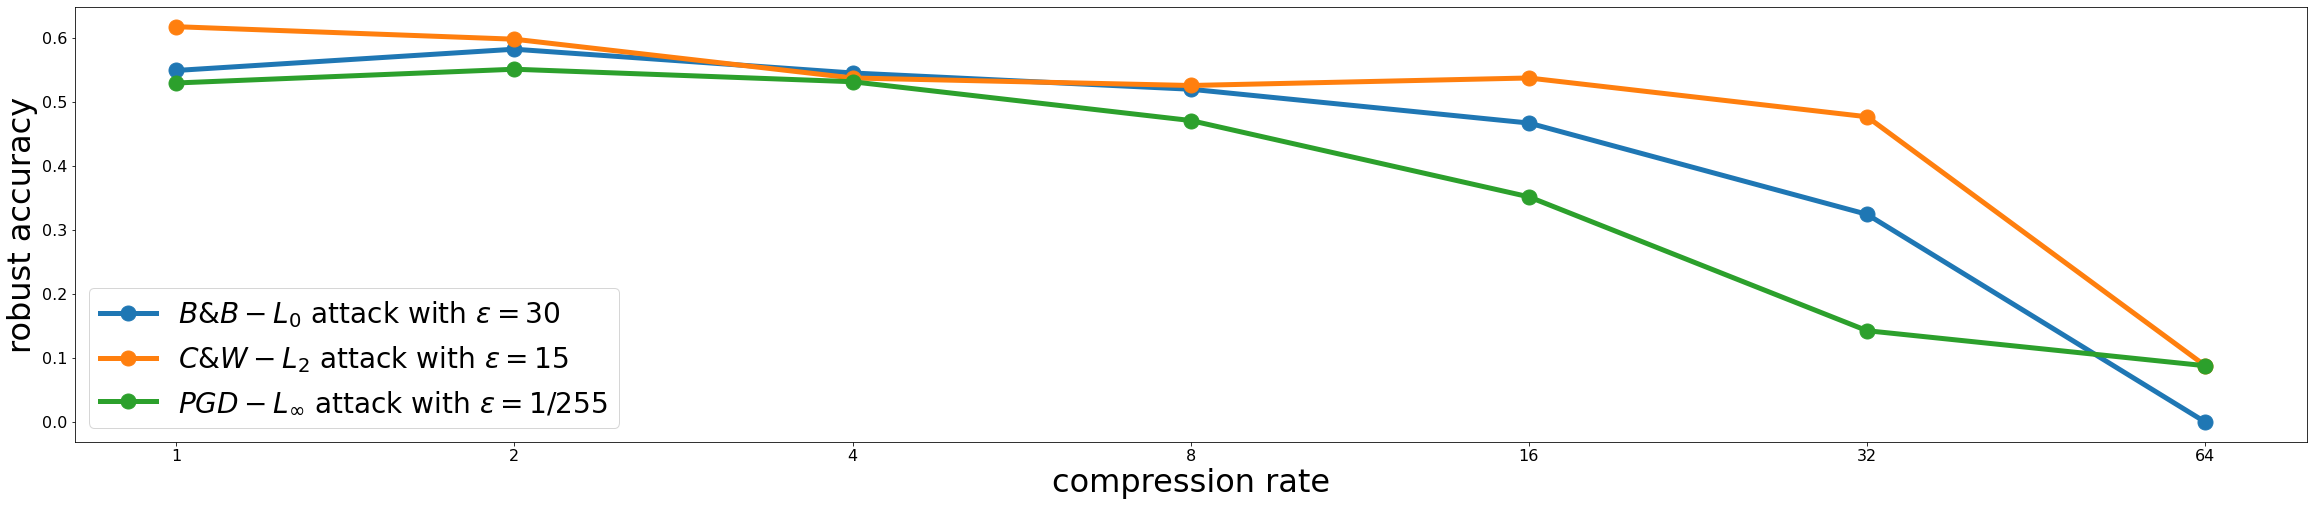

In [68]:
x_axis_label = 'compression rate'
y_axis_label = 'robust accuracy'
        
fig, axes = plt.subplots(ncols=1, nrows=1, sharey=True, gridspec_kw={'wspace': 0.05, 'hspace':.5})
#axes = axes.flatten()
    

x = test.plot(marker='o', markersize=15,figsize=(40,8), fontsize=16, linewidth=5, ax=axes)

x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)

x.legend(prop={'size': 28})
fig.savefig(f'./graphics/attack-metric.png', dpi=72, bbox_inches='tight')

In [153]:
import pickle
advs = 0
with (open('advs', "rb")) as openfile:
    advs = pickle.load(openfile)
advs

{'l0': {'original': <tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
  array([[[0.40784317, 0.14117648, 0.14509805],
          [0.40784317, 0.14117648, 0.14509805],
          [0.40784317, 0.14117648, 0.14509805],
          ...,
          [0.4023277 , 0.13926664, 0.13839366],
          [0.40784317, 0.14117648, 0.14509805],
          [0.40784317, 0.14117648, 0.14509805]],
  
         [[0.40784317, 0.14117648, 0.14509805],
          [0.40784317, 0.14117648, 0.14509805],
          [0.40784317, 0.14117648, 0.14509805],
          ...,
          [0.40088242, 0.13981093, 0.14342442],
          [0.40784317, 0.14117648, 0.14509805],
          [0.40784317, 0.14117648, 0.14509805]],
  
         [[0.40784317, 0.14117648, 0.14509805],
          [0.40784317, 0.14117648, 0.14509805],
          [0.40784317, 0.14117648, 0.14509805],
          ...,
          [0.4015796 , 0.13511123, 0.13112354],
          [0.40784317, 0.14117648, 0.14509805],
          [0.40784317, 0.14117648, 0.14509805]],
  
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(9, 13))
columns = 4
rows = 5

# prep (x,y) for extra plotting
xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
ys = np.abs(np.sin(xs))           # absolute of sine

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    img = np.random.randint(10, size=(h,w))
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("ax:"+str(i))  # set title
    plt.imshow(img, alpha=0.25)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<ipython-input-207-0a2e9f75f6b2>:31: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])  # note you need two lists one for the positions and one for the labels
<ipython-input-207-0a2e9f75f6b2>:32: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])  # same for y ticks


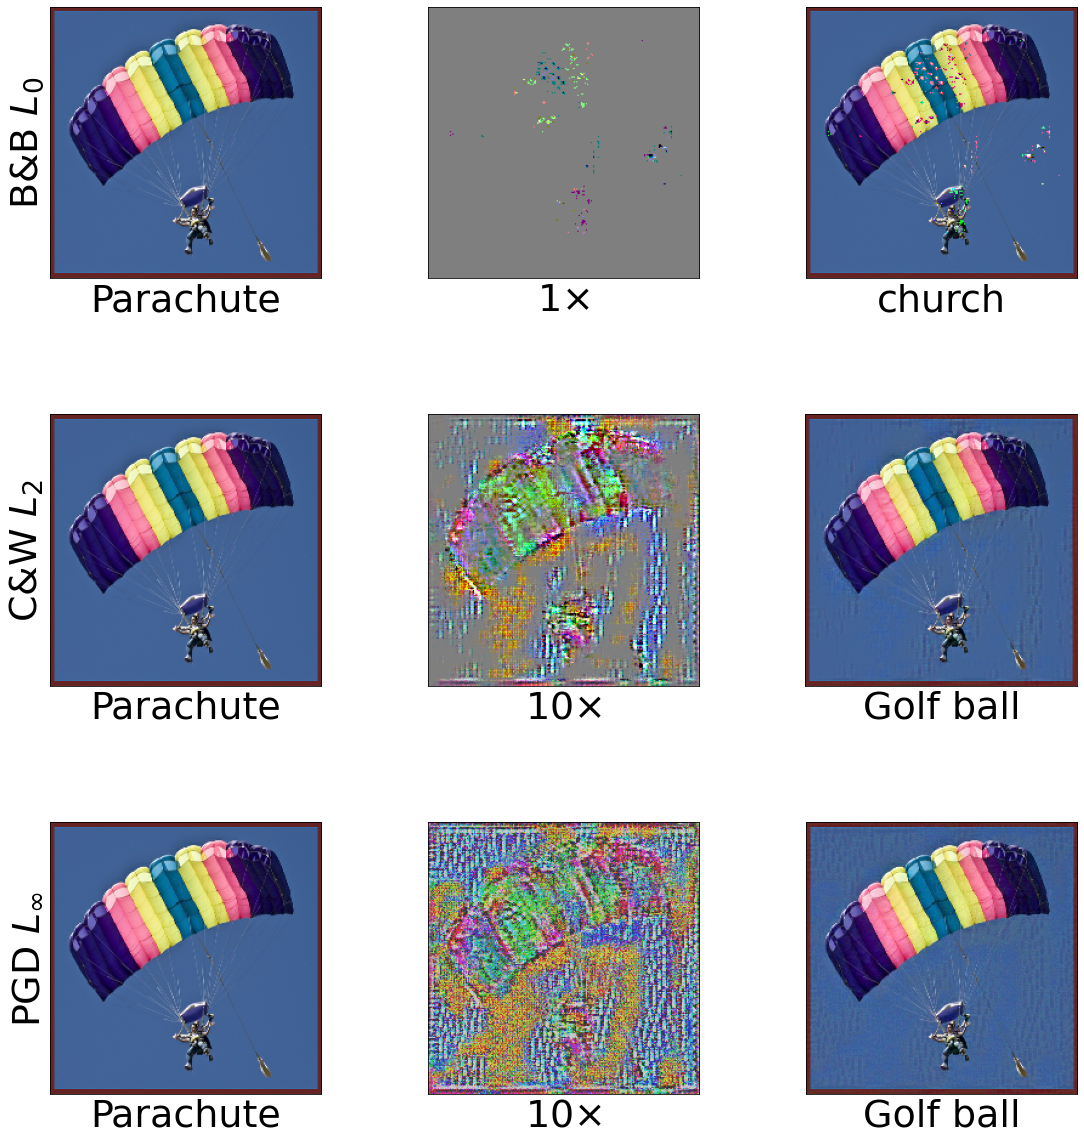

In [207]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(20,20) , gridspec_kw={'wspace': 0.05, 'hspace':.5})
axes = axes.flatten()

axes
axes[0].imshow(advs['l0']['original'])
axes[0].set_xlabel("Parachute", fontsize=38)
axes[0].set_ylabel(r"B&B $L_0$", fontsize=38)
axes[1].imshow(0.5+advs['l0']['perturbation'])
axes[1].set_xlabel(r"1$\times$", fontsize=38)
axes[2].imshow(advs['l0']['adversarial'])
axes[2].set_xlabel(r"church", fontsize=38)

axes[3].imshow(advs['l2']['original'])
axes[3].set_xlabel("Parachute", fontsize=38)
axes[3].set_ylabel(r"C&W $L_2$", fontsize=38)
axes[4].imshow(0.5+10*advs['l2']['perturbation'])
axes[4].set_xlabel(r"10$\times$", fontsize=38)
axes[5].imshow(advs['l2']['adversarial'])
axes[5].set_xlabel(r"Golf ball", fontsize=38)


axes[6].imshow(advs['linf']['original'])
axes[6].set_ylabel(r"PGD $L_\infty$", fontsize=38)
axes[6].set_xlabel("Parachute", fontsize=38)
axes[7].imshow(0.5+10*advs['linf']['perturbation'])
axes[7].set_xlabel(r"10$\times$", fontsize=38)
axes[8].imshow(advs['linf']['adversarial'])
axes[8].set_xlabel(r"Golf ball", fontsize=38)

for ax in axes:
    ax.set_xticks([], [])  # note you need two lists one for the positions and one for the labels
    ax.set_yticks([], [])  # same for y ticks



In [176]:
axes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15d041790>,
      dtype=object)

In [ ]:
x = l2.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[1])
x.set_title('L2', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)


x = l_inf.plot(marker='o', markersize=15,figsize=(40,20), fontsize=16, linewidth=5, ax=axes[2])
x.set_title('L inf', fontsize=40)
x.set_xscale('log')
x.set_xticks([1,2,4,8,16,32,64])
x.set_xticklabels([1,2,4,8,16,32,64] )
x.minorticks_off()
x.set_xlabel(x_axis_label, fontsize=32)
x.set_ylabel(y_axis_label, fontsize=32)